# Benchmark Models

## Model VAE

In [114]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAE, self).__init__()
        #Encoder
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)

        #dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

Loss Function

In [115]:
def zinb_loss(recon_x, x, mu, log_var, p0=None, beta=1.0, theta=1.0):
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()
        else:
            x = torch.tensor(x, dtype=torch.float32)

    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()
        else:
            recon_x = torch.tensor(recon_x, dtype=torch.float32)

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)

    nb_loss = -torch.sum(
        torch.lgamma(x + theta_tensor)
        - torch.lgamma(x + 1)
        - torch.lgamma(theta_tensor)
        + x * torch.log(torch.clamp(recon_x, min=1e-8))
        + theta_tensor * torch.log(theta_tensor / torch.clamp(recon_x, min=1e-8))
    )

    # if p0 do not provide we assume bernulli
    if p0 is None:
        bernoulli_loss = torch.tensor(0.0, device=x.device)
    else:
        p0 = torch.clamp(p0, min=1e-5, max=1 - 1e-5)
        bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = nb_loss + bernoulli_loss + beta * kl_loss

    return total_loss, nb_loss, bernoulli_loss, kl_loss


Training of the model

In [116]:
def train_model_vae(model, X, optimizer, num_epochs=200):
    model.train()
    total_losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon, mu, log_var = model(X)
        total_loss, nb_loss, bern_loss, kl_loss = zinb_loss(recon, X, mu, log_var)
        total_loss.backward()
        optimizer.step()

        total_losses.append(total_loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bern_loss.item())
        kl_losses.append(kl_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] - Total: {total_loss.item():.4f}, NB: {nb_loss.item():.4f}, Bernoulli: {bern_loss.item():.4f}, KL: {kl_loss.item():.4f}")

    return total_losses, nb_losses, bernoulli_losses, kl_losses

#### Clusterization for VAE

In [394]:
def clustering_and_metrics(mu, X_data):
    # Latent representation (mu)
    adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
    # Preprocessing UMAP
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
    sc.tl.umap(adata_latent)
    
    # clustering resolutions
    resolutions = [0.4, 0.6, 0.8]
    methods = ['leiden', 'louvain']
    clustering_results = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    i = 0

    for method in methods:
        for res in resolutions:
            key = f"{method}_r"
            
            #Leiden o Louvain
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)
            # clusters lablels
            labels = adata_latent.obs[key].astype(int).values
            n_clusters = len(set(labels))
            silh = silhouette_score(adata_latent.obsm['X_umap'], labels) if n_clusters > 1 else -1
            ch = calinski_harabasz_score(adata_latent.obsm['X_umap'], labels) if n_clusters > 1 else -1
            
            clustering_results.append({
                'method': method,
                'resolution': res,
                'n_clusters': n_clusters,
                'silhouette': silh,
                'calinski_harabasz': ch
            })

            axs[i].scatter(adata_latent.obsm['X_umap'][:, 0], adata_latent.obsm['X_umap'][:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
            axs[i].set_xlabel("UMAP1")
            axs[i].set_ylabel("UMAP2")
            i += 1

    plt.tight_layout()
    plt.show()

    return clustering_results


### Hyperparametrization of VAE

In [ ]:
# GridSEARCH
def hyperparameter_search(X, input_dim, num_epochs):
    param_grid = {
        'hidden_dim': [64, 128, 256],
        'latent_dim': [32, 64, 128],
        'dropout_rate': [0.1, 0.2, 0.3],
        'learning_rate': [1e-3, 1e-4, 1e-5]
    }

    best_score = float('inf')
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        model = VAE(input_dim, params['hidden_dim'], params['latent_dim'], dropout_rate=params['dropout_rate'])
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        losses, nb_losses, bernoulli_losses, kl_losses = train_model_vae(model, X, optimizer, num_epochs, verbose=1)
        
        # Evaluar métricas
        final_loss = losses[-1]
        if final_loss < best_score:
            best_score = final_loss
            best_params = params
            best_model = model

    return best_model, best_params

In [ ]:
input_dim = adata_filtered.shape[1]
X_data = adata_filtered.X
X = torch.FloatTensor(X_data)
num_epochs = 200
best_model, best_params = hyperparameter_search(X, input_dim, num_epochs)


In [ ]:
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'dropout_rate': 0.1, 'hidden_dim': 256, 'latent_dim': 64, 'learning_rate': 0.001}


In [182]:
#Using the best parameters
X_data = adata_filtered.X 
dropout_rate = 0.1
hidden_dim = 256
latent_dim = 64
learning_rate = 0.001
num_epochs = 200
input_dim = X_data.shape[1]

In [ ]:
# Model
vae_model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate=dropout_rate)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
X_data_tensor = torch.tensor(X_data, dtype=torch.float32) #tensor
total_losses, nb_losses, bernoulli_losses, kl_losses = train_model_vae(vae_model, X_data_tensor, optimizer, num_epochs=200)


Epoch [1/200] - Loss: -35418488.0000, NB Loss: -37964192.0000, Bernoulli Loss: 2543674.2500, KL Loss: 2029.6763
Epoch [2/200] - Loss: -37713400.0000, NB Loss: -40230984.0000, Bernoulli Loss: 2515098.0000, KL Loss: 2486.4631
Epoch [3/200] - Loss: -39879964.0000, NB Loss: -42370092.0000, Bernoulli Loss: 2487028.5000, KL Loss: 3101.0100
Epoch [4/200] - Loss: -41845732.0000, NB Loss: -44310336.0000, Bernoulli Loss: 2460814.0000, KL Loss: 3789.5840
Epoch [5/200] - Loss: -43725440.0000, NB Loss: -46164072.0000, Bernoulli Loss: 2434234.5000, KL Loss: 4395.9697
Epoch [6/200] - Loss: -45640240.0000, NB Loss: -48051340.0000, Bernoulli Loss: 2405989.2500, KL Loss: 5110.0586
Epoch [7/200] - Loss: -47352604.0000, NB Loss: -49737672.0000, Bernoulli Loss: 2379326.5000, KL Loss: 5740.4888
Epoch [8/200] - Loss: -49136532.0000, NB Loss: -51492504.0000, Bernoulli Loss: 2349561.2500, KL Loss: 6410.7227
Epoch [9/200] - Loss: -50843952.0000, NB Loss: -53170100.0000, Bernoulli Loss: 2319000.5000, KL Loss: 71

Performance loss functions

In [217]:
# Function for the plots
def plot_losses(total_losses, nb_losses,bernoulli_losses, kl_losses):
    epochs = range(1, len(total_losses) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, total_losses, label='Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, nb_losses, label='Negative Binomial Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("NB Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, bernoulli_losses, label='Bernoulli Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Bernoulli Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, kl_losses, label='KL Divergence Loss', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("KL Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

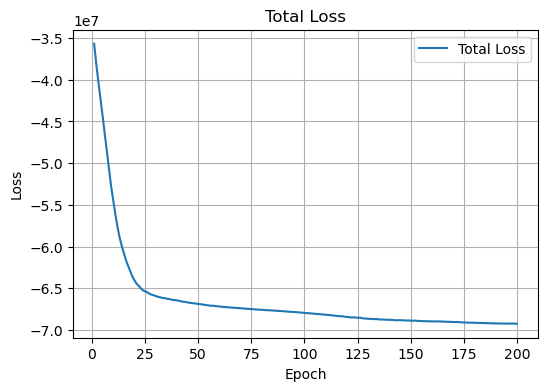

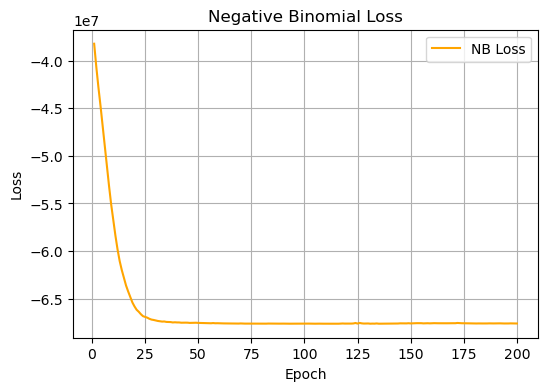

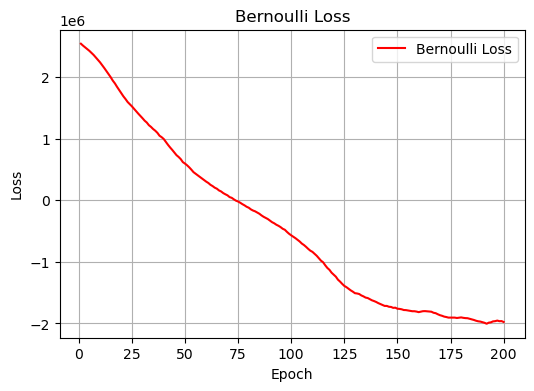

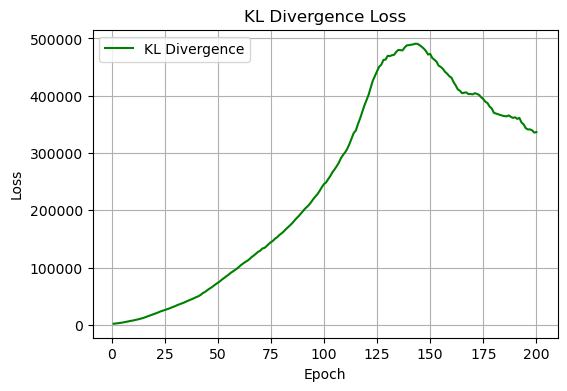

In [ ]:
plot_losses(total_losses, nb_losses, bernoulli_losses, kl_losses)

#### Clusters of VAE

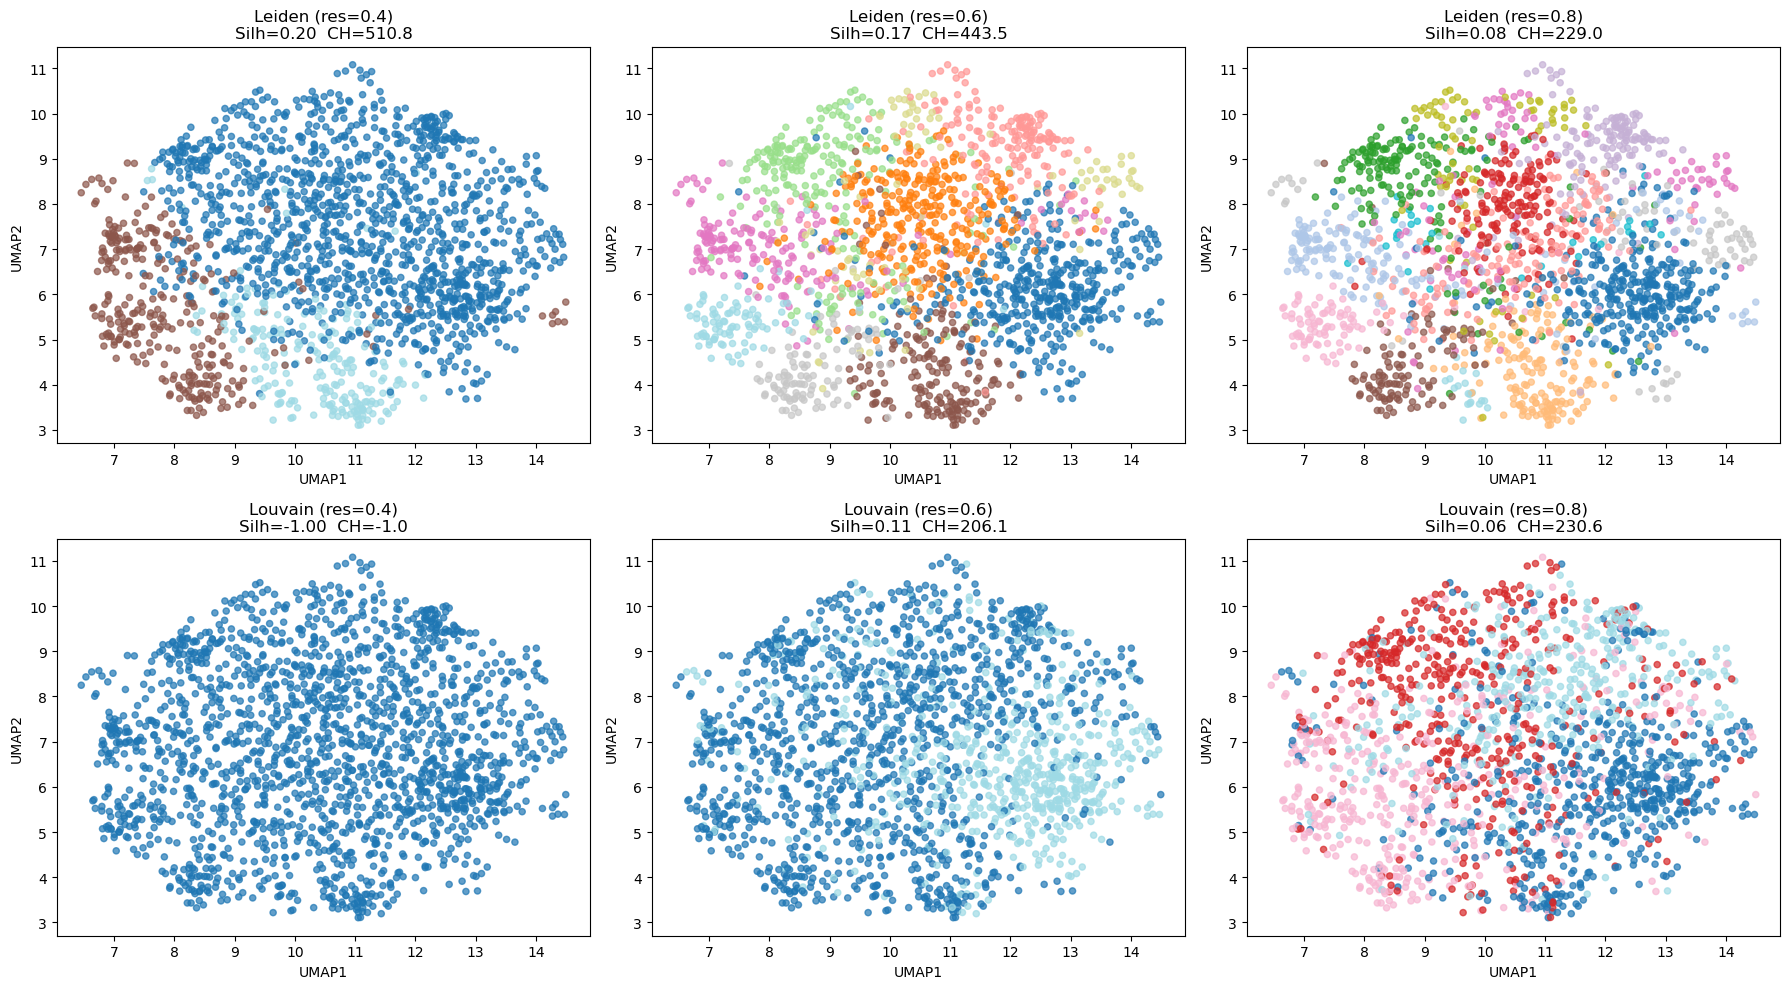

In [ ]:
if not isinstance(X_data, torch.Tensor):
    X_data = torch.tensor(X_data, dtype=torch.float32)


device = next(vae_model.parameters()).device
X_data = X_data.to(device)

# Latent representations
mu, log_var = vae_model.encode(X_data)
clustering_results = clustering_and_metrics(mu, X_data) #clustering

### Evaluation Metrics

In [251]:
def evaluate_model(model, X_data):
    model.eval()
    with torch.no_grad():
        recon, mu, log_var = model(X_data)
    mu_np = mu.cpu().numpy()
    X_np = X_data.cpu().numpy()
    recon_np = recon.cpu().numpy()

    # Reconstruction metrics
    mse = mean_squared_error(X_np.flatten(), recon_np.flatten())
    pearson_corr = pearsonr(X_np.flatten(), recon_np.flatten())[0]
    latent_normality_pval = normaltest(mu_np, axis=0).pvalue.mean()

    # Cluster analysis
    adata_latent = sc.AnnData(X=mu_np)
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X")
    sc.tl.umap(adata_latent)

    methods = ["leiden", "louvain"]
    resolutions = [0.4, 0.6, 0.8]
    records = []

    for method in methods:
        for res in resolutions:
            key = f"{method}_r{res}"
            if method == "leiden":
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            if len(set(labels)) > 1:
                silh = silhouette_score(adata_latent.obsm["X_umap"], labels)
                ch = calinski_harabasz_score(adata_latent.obsm["X_umap"], labels)
            else:
                silh, ch = -1, -1

            records.append({
                "Metric": "Silhouette Score",
                "VAE": silh,
                "Method": method,
                "Resolution": res
            })
            records.append({
                "Metric": "Calinski-Harabasz Index",
                "VAE": ch,
                "Method": method,
                "Resolution": res
            })

    # df
    records.extend([
        {"Metric": "MSE", "VAE": mse, "Method": None, "Resolution": None},
        {"Metric": "Pearson Correlation", "VAE": pearson_corr, "Method": None, "Resolution": None},
        {"Metric": "Latent Space Normality (p-value)", "VAE": latent_normality_pval, "Method": None, "Resolution": None}
    ])

    return pd.DataFrame(records)

In [253]:
device = next(vae_model.parameters()).device
X_data_tensor = X_data_tensor.to(device)
metrics_df = evaluate_model(vae_model, X_data_tensor)

```{admonition} Calinski-Harabaz Index
The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, is a metric used to evaluate the quality of clustering results. It measures how well the clusters are separated and how compact they are. Specifically, it is the ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion. A higher Calinski-Harabasz score indicates better-defined clusters

The Calinski-Harabasz Index (CH) is defined as:

$$
\text{CH} = \frac{ \text{Tr}(B_k) / (k - 1) }{ \text{Tr}(W_k) / (n - k) }
$$

Where:  
- \( \text{Tr}(B_k) \) is the trace of the between-cluster dispersion matrix  
- \( \text{Tr}(W_k) \) is the trace of the within-cluster dispersion matrix  
- \( k \) is the number of clusters  
- \( n \) is the total number of data points
```

In [258]:
import pandas as pd

# Datos originales
data = [
    ["Silhouette Score", 0.195177, "leiden", 0.4],
    ["Calinski-Harabasz Index", 510.820769, "leiden", 0.4],
    ["Silhouette Score", 0.171419, "leiden", 0.6],
    ["Calinski-Harabasz Index", 443.458888, "leiden", 0.6],
    ["Silhouette Score", 0.076785, "leiden", 0.8],
    ["Calinski-Harabasz Index", 229.003893, "leiden", 0.8],
    ["Silhouette Score", -1.0, "louvain", 0.4],
    ["Calinski-Harabasz Index", -1.0, "louvain", 0.4],
    ["Silhouette Score", 0.106973, "louvain", 0.6],
    ["Calinski-Harabasz Index", 206.088366, "louvain", 0.6],
    ["Silhouette Score", 0.061618, "louvain", 0.8],
    ["Calinski-Harabasz Index", 230.627533, "louvain", 0.8],
    ["MSE", 0.794525, None, None],
    ["Pearson Correlation", 0.000289, None, None],
    ["Latent Space Normality (p-value)", 0.425853, None, None]
]

# Crear DataFrame
df = pd.DataFrame(data, columns=["Metric", "VAE", "Method", "Resolution"])

# Reordenar columnas para que 'VAE' esté al final
column_order = ["Metric", "Method", "Resolution", "VAE"]
df = df[column_order]

# Mostrar la tabla final
# print(df)


In [ ]:
metrics_df

Metric   Method  Resolution         VAE
0                   Silhouette Score   leiden         0.4    0.195177
1            Calinski-Harabasz Index   leiden         0.4  510.820769
2                   Silhouette Score   leiden         0.6    0.171419
3            Calinski-Harabasz Index   leiden         0.6  443.458888
4                   Silhouette Score   leiden         0.8    0.076785
5            Calinski-Harabasz Index   leiden         0.8  229.003893
6                   Silhouette Score  louvain         0.4   -1.000000
7            Calinski-Harabasz Index  louvain         0.4   -1.000000
8                   Silhouette Score  louvain         0.6    0.106973
9            Calinski-Harabasz Index  louvain         0.6  206.088366
10                  Silhouette Score  louvain         0.8    0.061618
11           Calinski-Harabasz Index  louvain         0.8  230.627533
12                               MSE     None         NaN    0.794525
13               Pearson Correlation     None         NaN    0.000289
14  Latent Space Normality (p-value)     None         NaN    0.425853

### Differential Expression for VAE

The green vertical lines represent log fold change thresholds (typically at +1 and -1).

The blue horizontal line represents the p-value threshold (typically at p = 0.05, shown as -log10(0.05) on the y-axis).

If a point (gene) is outside these lines, it means:
To the right of the green line (> +1 logFC):
The gene is strongly upregulated in the cluster compared to the others.

To the left of the green line (< -1 logFC):
The gene is strongly downregulated in the cluster compared to the others.

Above the blue line:
The gene is statistically significant, because its p-value is less than 0.05.

So if a gene is:
Beyond the green lines and above the blue line, it's considered both:

Statistically significant

Biologically meaningful (large expression change)

These genes (points) are often colored red in the plot because they are the most relevant for biological interpretation.

In [196]:
print(adata_filtered.obs.columns)


Index(['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type',
       'neoplastic_state', 'diagnosis', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'mito_UMI_counts', 'pct_mito',
       'doublet_score', 'predicted_doublet'],
      dtype='object')


In [ ]:
vae_model.eval()
with torch.no_grad():
    x_tensor = torch.Tensor(adata_filtered.X.A if hasattr(adata_filtered.X, "A") else adata_filtered.X).to(device)
    mu, _ = vae_model.encode(x_tensor)
    latent = mu.cpu().numpy()


In [ ]:
# Lattent embeddings for VAE
adata_filtered.obsm["X_latent"] = latent


In [ ]:
print(adata_filtered.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_umap, X_harmony, X_latent)


In [200]:
sc.pp.neighbors(adata_filtered, use_rep="X_latent", n_neighbors=15)

In [201]:
sc.tl.leiden(adata_filtered, resolution=0.6, key_added="leiden_0.6")


In [202]:
sc.tl.rank_genes_groups(
    adata_filtered,
    groupby="leiden_0.6",
    method="wilcoxon",
    use_raw=False
)


| Cluster | Top Marker Genes                         | Probable Cell Type                       | Description                                                                                                                              |
| ------- | ---------------------------------------- | ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| 0       | ZNF225, RERG, TGFBR3, WNT7B, PLA1A       | Tumor cells / possibly epithelial-like   | Genes related to growth signaling and differentiation. May correspond to tumor or modified progenitor cells.                            |
| 1       | RNF227, RASGEF1B, CLEC2B, HLA-DRB5, CD74 | Antigen-presenting cells (APCs)          | High expression of HLA and CD74 genes indicates antigen-presenting cells such as dendritic cells or activated microglia.                |
| 2       | RBX1, PCDHGA6, FCRLA, MS4A1, CD79B       | B cells                                  | Typical genes of B-cell receptors and immune signaling pathways.                                                                         |
| 3       | RMP, IGFBP2, CRABP1, HSPB1, TUBB2A       | Tumor cells / glioma-like                | IGFBP2 and other proliferation-related genes suggest a tumor cell identity.                                                              |
| 4       | TANC6, C2, SCIN, MOB1B, BCL2A1P4         | Stromal / mesenchymal-like cells         | Genes related to cytoskeleton, cell signaling, and survival; possibly stromal or mesenchymal cells in the tumor microenvironment.        |
| 5       | CCL13, DPH3, PDE3B, CCL2, TNF            | Pro-inflammatory macrophages / Monocytes | High expression of chemokines and TNF suggests pro-inflammatory macrophages or infiltrating monocytes.                                  |


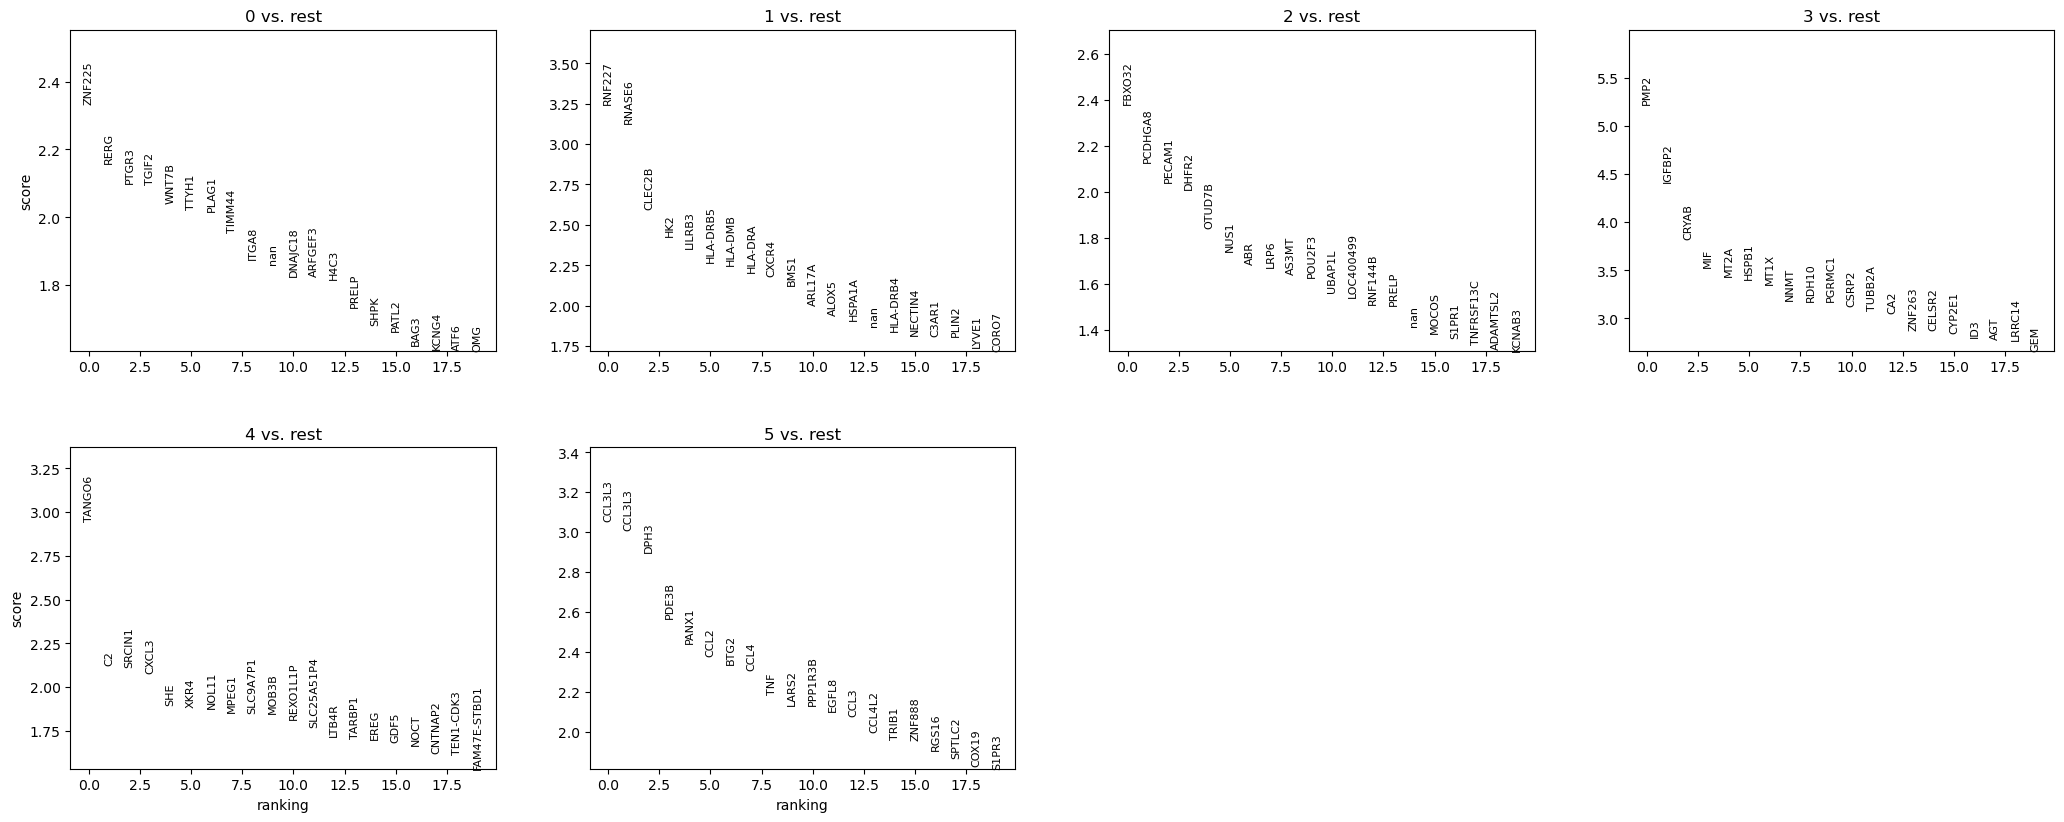

In [ ]:
# Map each differential Gene
adata_filtered.var['gene_symbols'] = adata_filtered.var['Mapped_Gene']
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False, gene_symbols='gene_symbols')


In [ ]:
groups = adata_filtered.uns['rank_genes_groups']['names'].dtype.names #Name of each cluster

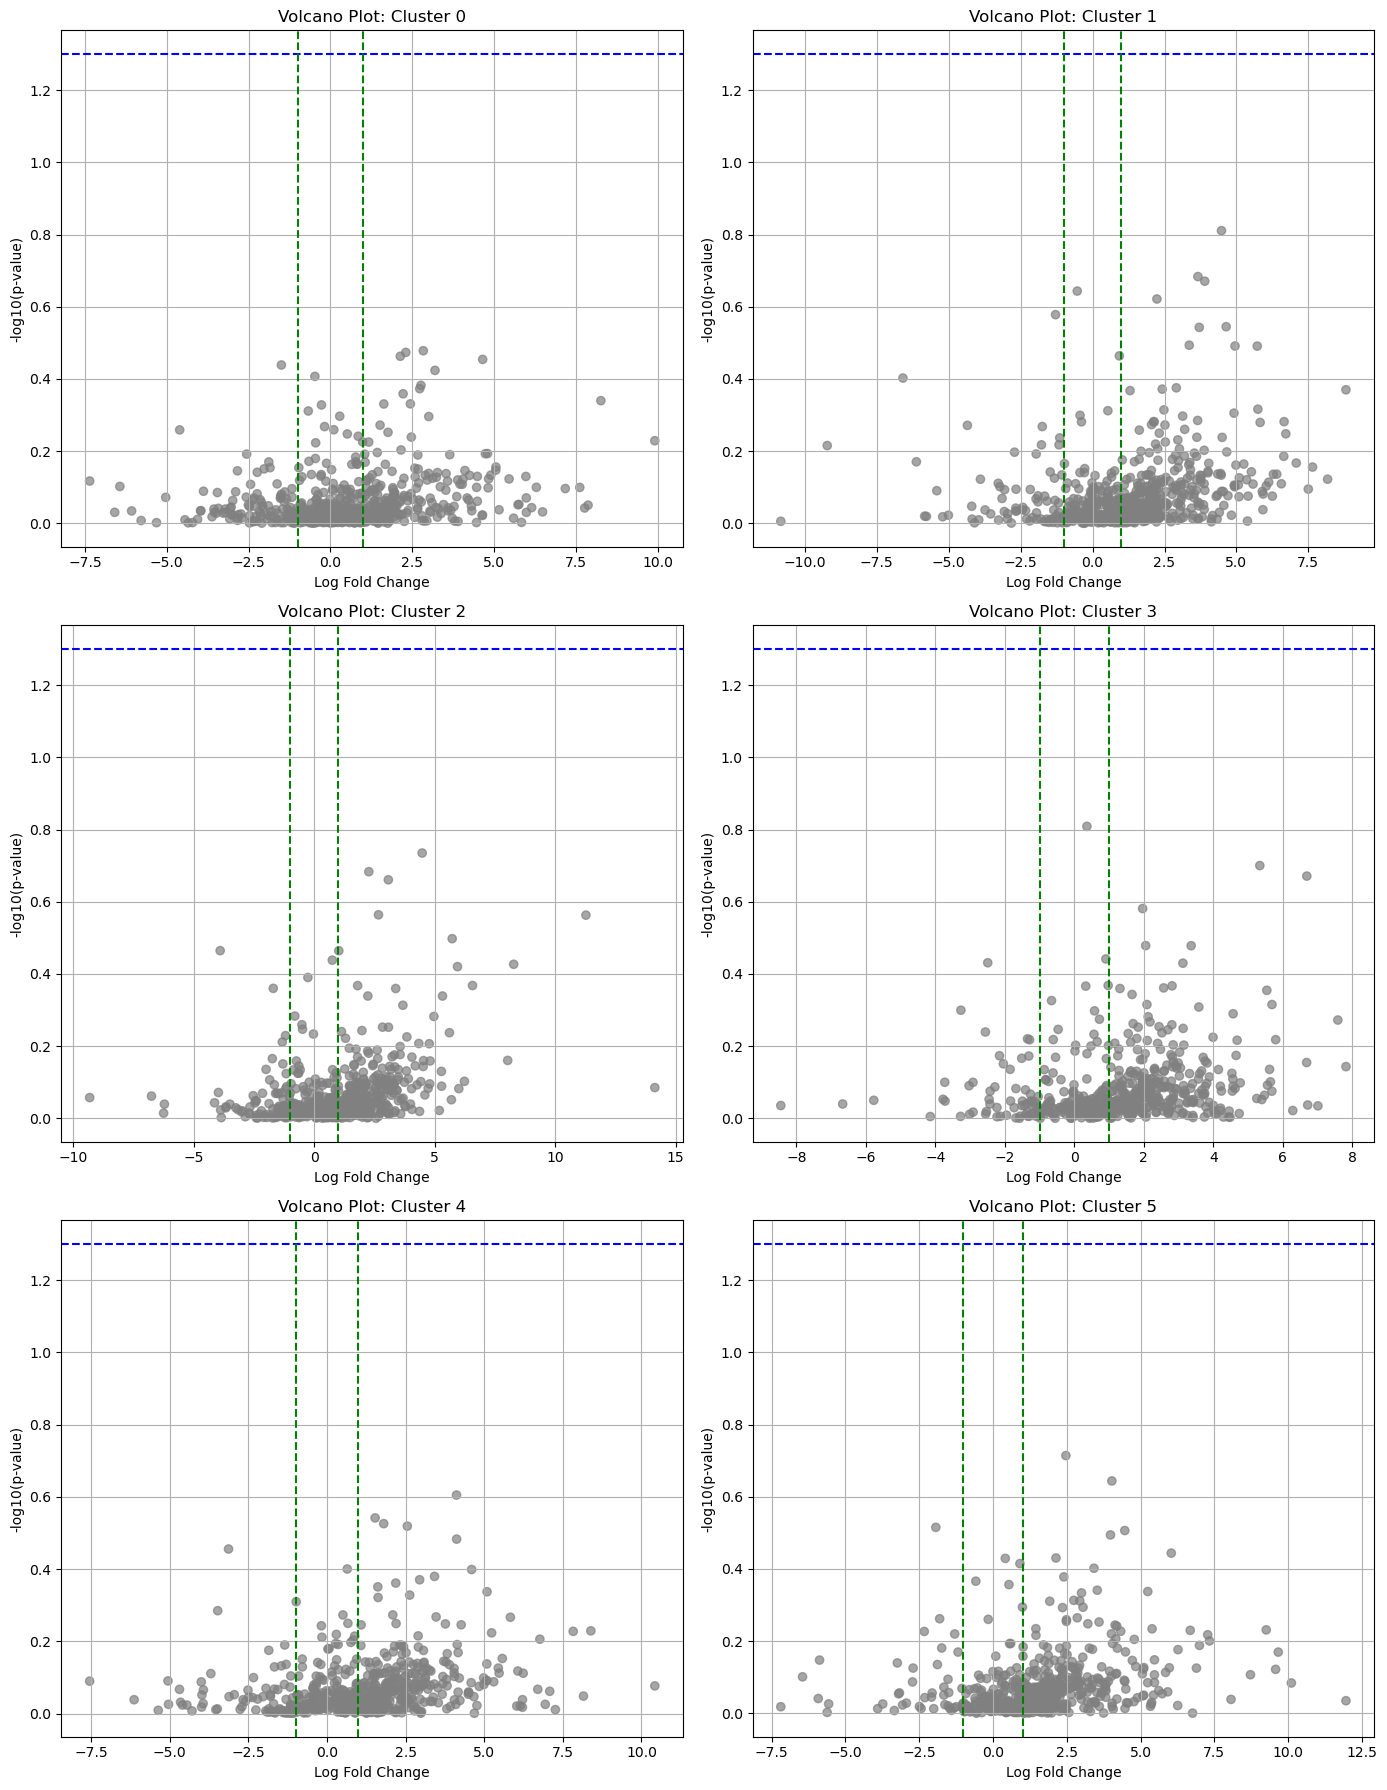

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 18))
axs = axs.flatten()

for i, group in enumerate(groups):
    if i >= len(axs): #depends on the number of the cluster
        break

    names = adata_filtered.uns['rank_genes_groups']['names'][group]
    logfc = adata_filtered.uns['rank_genes_groups']['logfoldchanges'][group]
    pvals = adata_filtered.uns['rank_genes_groups']['pvals'][group]

    # Data for the volcano plot
    volcano_df = pd.DataFrame({
        'gene': names,
        'logFC': logfc,
        'pval': pvals
    })

    # -log10(p-value)
    volcano_df['neg_log10_pval'] = -np.log10(volcano_df['pval'])

    # Significative genes
    volcano_df['significant'] = (volcano_df['pval'] < 0.05) & (abs(volcano_df['logFC']) > 1)

    ax = axs[i]
    ax.scatter(volcano_df['logFC'], volcano_df['neg_log10_pval'],
               c=volcano_df['significant'].map({True: 'red', False: 'gray'}),
               alpha=0.7)
    ax.set_title(f'Volcano Plot: Cluster {group}')
    ax.set_xlabel('Log Fold Change')
    ax.set_ylabel('-log10(p-value)')
    ax.axhline(-np.log10(0.05), color='blue', linestyle='--')
    ax.axvline(1, color='green', linestyle='--')
    ax.axvline(-1, color='green', linestyle='--')
    ax.grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## VAE + Attention

In [220]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
    
    def forward(self, x):
        attn_output, _ = self.attention_layer(x, x, x)
        return attn_output

In [221]:
class VAEAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(VAEAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.fc_enc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.attn = Attention(hidden_dim)
        
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc_dec3 = nn.Linear(hidden_dim * 2, input_dim)
        
        self.fc_p0 = nn.Linear(latent_dim, input_dim)
        
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        h = F.elu(self.fc_enc1(x))
        h = self.dropout(h)
        h = F.elu(self.fc_enc2(h))
        h = self.dropout(h)
        
        h = h.unsqueeze(1)
        h = self.attn(h)
        h = h.squeeze(1)
        
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc_dec1(z))
        h = self.dropout(h)
        h = F.elu(self.fc_dec2(h))
        h = self.dropout(h)
        return self.fc_dec3(h)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        p0 = torch.sigmoid(self.fc_p0(mu))
        return self.decode(z), mu, log_var, p0

In [222]:
#Loss functions 
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    if isinstance(x, torch.Tensor):
        if x.is_sparse:
            x = x.to_dense()
        else:
            x = torch.tensor(x, dtype=torch.float32)

    if isinstance(recon_x, torch.Tensor):
        if recon_x.is_sparse:
            recon_x = recon_x.to_dense()
        else:
            recon_x = torch.tensor(recon_x, dtype=torch.float32)

    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - 
                         torch.lgamma(theta_tensor) + x * torch.log(torch.clamp(recon_x, min=1e-8) + 1e-8) + 
                         theta_tensor * torch.log(theta_tensor / (torch.clamp(recon_x, min=1e-8) + 1e-8)))

    p0 = torch.clamp(p0, min=1e-5, max=1-1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))

    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [223]:
#Function to train the model
def train_model_vae_attention(model, X, optimizer, num_epochs=200, verbose=1):
    model.train()
    losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, log_var, p0 = model(X)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_batch, X, mu, log_var, p0)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        losses.append(loss.item())
        nb_losses.append(nb_loss.item())
        bernoulli_losses.append(bernoulli_loss.item())
        kl_losses.append(kl_loss.item())

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}, NB Loss: {nb_loss.item():.4f}, "
                  f"Bernoulli Loss: {bernoulli_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}")

    return losses, nb_losses, bernoulli_losses, kl_losses

In [224]:
# Function to perform clustering and calculate metrics 
def clustering_and_metrics(X_data, mu):
    # UMAP
    adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
    sc.tl.umap(adata_latent)
    umap_coords = adata_latent.obsm['X_umap']

    resolutions = [0.4, 0.6, 0.8]
    methods = ['leiden', 'louvain']
    clustering_results = []

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    i = 0

    for method in methods:
        for res in resolutions:
            key = f"{method}_r"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            n_clusters = len(set(labels))
            silh = silhouette_score(umap_coords, labels) if n_clusters > 1 else -1
            ch = calinski_harabasz_score(umap_coords, labels) if n_clusters > 1 else -1

            clustering_results.append({
                'method': method,
                'resolution': res,
                'n_clusters': n_clusters,
                'silhouette': silh,
                'calinski_harabasz': ch
            })

            axs[i].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
            axs[i].set_xlabel("UMAP1")
            axs[i].set_ylabel("UMAP2")
            i += 1

    plt.tight_layout()
    plt.show()

    return clustering_results

### Hyperparametrization of the model VAE + Attention

In [ ]:

def hyperparameter_tuning(X_data):
    # Hiyperparameters
    param_grid = {
        'hidden_dim': [64, 128, 256],  
        'latent_dim': [32, 64, 128],  
        'dropout_rate': [0.1, 0.3, 0.5],  
        'learning_rate': [1e-3, 1e-4, 1e-5] 
    }
    
    grid = ParameterGrid(param_grid)
    
    best_metrics = {
        'best_loss': float('inf'),
        'best_params': None,
        'best_silhouette': -1,
        'best_calinski': -1,
        'best_pearson': -1
    }

    # Searching for the best hyperparameters
    for params in grid:
        print(f"Training with params: {params}")
        
        # Model with hyperparameters
        vae_model = VAEAttention(
            input_dim=X_data.shape[1],
            hidden_dim=params['hidden_dim'],
            latent_dim=params['latent_dim'],
            dropout_rate=params['dropout_rate']
        )
        optimizer = optim.Adam(vae_model.parameters(), lr=params['learning_rate'])
        X_tensor = torch.tensor(X_data, dtype=torch.float32)
        num_epochs = 200
        vae_losses, vae_nb_losses, vae_kl_losses = train_model_vae(vae_model, X_tensor, optimizer, num_epochs)
        
        # Latent representation
        X_tensor = torch.tensor(X_data, dtype=torch.float32) 
        vae_embeddings_umap = vae_model.encode(X_tensor)[0].detach().numpy()
        
        # Clustering con Louvain y Leiden
        adata = sc.AnnData(vae_embeddings_umap)
        sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
        sc.tl.leiden(adata, resolution=0.6)
        sc.tl.louvain(adata, resolution=0.6)

        leiden_labels = adata.obs['leiden'].values
        louvain_labels = adata.obs['louvain'].values
        le = LabelEncoder()
        leiden_labels = le.fit_transform(leiden_labels)
        louvain_labels = le.fit_transform(louvain_labels)
        
        if len(set(leiden_labels)) > 1:
            silhouette_leiden = silhouette_score(vae_embeddings_umap, leiden_labels)
            calinski_leiden = calinski_harabasz_score(vae_embeddings_umap, leiden_labels)
        else:
            silhouette_leiden = None
            calinski_leiden = None

        if len(set(louvain_labels)) > 1:
            silhouette_louvain = silhouette_score(vae_embeddings_umap, louvain_labels)
            calinski_louvain = calinski_harabasz_score(vae_embeddings_umap, louvain_labels)
        else:
            silhouette_louvain = None
            calinski_louvain = None
        
        # Pearson Correlation
        pearson_corr_leiden = np.corrcoef(vae_embeddings_umap.T, leiden_labels)[-1, :-1]
        pearson_corr_louvain = np.corrcoef(vae_embeddings_umap.T, louvain_labels)[-1, :-1]
        
        if silhouette_leiden > best_metrics['best_silhouette']:
            best_metrics['best_silhouette'] = silhouette_leiden
            best_metrics['best_params'] = params
        if calinski_leiden > best_metrics['best_calinski']:
            best_metrics['best_calinski'] = calinski_leiden
        if pearson_corr_leiden[0] > best_metrics['best_pearson']:
            best_metrics['best_pearson'] = pearson_corr_leiden[0]
    
    return best_metrics

In [ ]:
X_data = adata_filtered.X  
best_metrics = hyperparameter_tuning(X_data)

In [ ]:
print(f"Best metrics: {best_metrics}")

Best hyperparameters: {'dropout_rate': 0.1, 'hidden_dim': 256, 'latent_dim': 64, 'learning_rate': 0.001}


Training the model with the best parameters

In [225]:
def evaluate_model_attention_ordered(model, X_data):
    model.eval()
    with torch.no_grad():
        recon, mu, log_var, _ = model(X_data)
    mu_np = mu.cpu().numpy()
    X_np = X_data.cpu().numpy()
    recon_np = recon.cpu().numpy()

    mse = mean_squared_error(X_np.flatten(), recon_np.flatten())
    pearson_corr = pearsonr(X_np.flatten(), recon_np.flatten())[0]
    latent_normality_pval = normaltest(mu_np, axis=0).pvalue.mean()

    adata_latent = sc.AnnData(X=mu_np)
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X")
    sc.tl.umap(adata_latent)

    metrics = []
    methods = ['leiden', 'louvain']
    resolutions = [0.4, 0.6, 0.8]

    for method in methods:
        for res in resolutions:
            key = f"{method}_r{res}"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            if len(set(labels)) > 1:
                silh = silhouette_score(adata_latent.obsm['X_umap'], labels)
                ch = calinski_harabasz_score(adata_latent.obsm['X_umap'], labels)
            else:
                silh, ch = np.nan, np.nan

            metrics.append({'Metric': 'Silhouette Score', 'VAE+Attention': silh, 'Method': method, 'Resolution': res})
            metrics.append({'Metric': 'Calinski-Harabasz Index', 'VAE+Attention': ch, 'Method': method, 'Resolution': res})

    metrics.extend([
        {'Metric': 'MSE', 'VAE+Attention': mse, 'Method': np.nan, 'Resolution': np.nan},
        {'Metric': 'Pearson Correlation', 'VAE+Attention': pearson_corr, 'Method': np.nan, 'Resolution': np.nan},
        {'Metric': 'Latent Space Normality (p-value)', 'VAE+Attention': latent_normality_pval, 'Method': np.nan, 'Resolution': np.nan}
    ])

    df_metrics = pd.DataFrame(metrics)
    return df_metrics

In [226]:
def plot_losses(losses, nb_losses, bernoulli_losses, kl_losses):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, losses, label='Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, nb_losses, label='Negative Binomial Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Negative Binomial Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, bernoulli_losses, label='Bernoulli Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Bernoulli Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, kl_losses, label='KL Divergence Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("KL Divergence Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


In [227]:
input_dim = X_data_tensor.shape[1]
best_params = {'dropout_rate': 0.1, 'hidden_dim': 256, 'latent_dim': 32, 'learning_rate': 0.001}

model_attention = VAEAttention(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    latent_dim=best_params['latent_dim'],
    dropout_rate=best_params['dropout_rate']
)
optimizer = optim.Adam(model_attention.parameters(), lr=best_params['learning_rate'])

In [ ]:
# Train
num_epochs = 200
losses, nb_losses, bernoulli_losses, kl_losses = train_model_vae_attention(
    model_attention, X_data_tensor, optimizer, num_epochs=num_epochs, verbose=1
)

C:\Users\henry\AppData\Local\Temp\ipykernel_31552\1573912572.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\henry\AppData\Local\Temp\ipykernel_31552\1573912572.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon_x = torch.tensor(recon_x, dtype=torch.float32)


Epoch [1/200] - Loss: -34626948.0000, NB Loss: -37153008.0000, Bernoulli Loss: 2525831.0000, KL Loss: 229.0655
Epoch [2/200] - Loss: -34635184.0000, NB Loss: -37148312.0000, Bernoulli Loss: 2512681.2500, KL Loss: 449.4211
Epoch [3/200] - Loss: -34545668.0000, NB Loss: -37044552.0000, Bernoulli Loss: 2497566.0000, KL Loss: 1316.4380
Epoch [4/200] - Loss: -34546528.0000, NB Loss: -37023540.0000, Bernoulli Loss: 2474118.5000, KL Loss: 2891.1189
Epoch [5/200] - Loss: -34457252.0000, NB Loss: -36899796.0000, Bernoulli Loss: 2435976.5000, KL Loss: 6566.5381
Epoch [6/200] - Loss: -34273352.0000, NB Loss: -36670332.0000, Bernoulli Loss: 2380245.2500, KL Loss: 16735.4004
Epoch [7/200] - Loss: -34060140.0000, NB Loss: -36416084.0000, Bernoulli Loss: 2320271.0000, KL Loss: 35671.7266
Epoch [8/200] - Loss: -33821952.0000, NB Loss: -36133544.0000, Bernoulli Loss: 2255565.5000, KL Loss: 56026.3047
Epoch [9/200] - Loss: -33917216.0000, NB Loss: -36164784.0000, Bernoulli Loss: 2190638.5000, KL Loss: 5

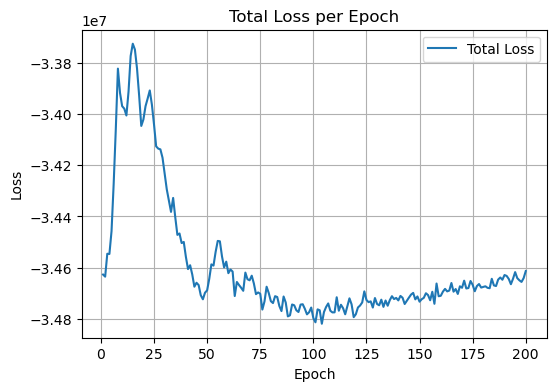

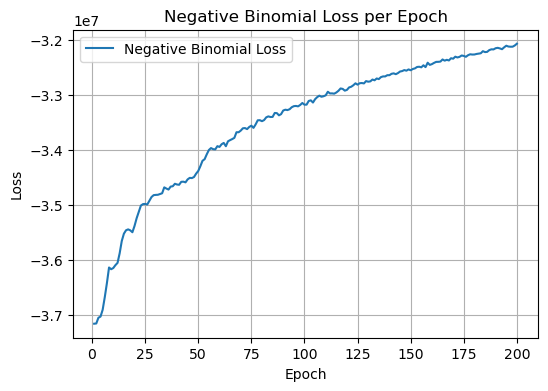

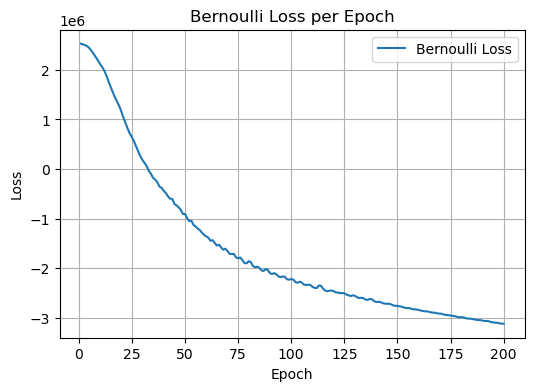

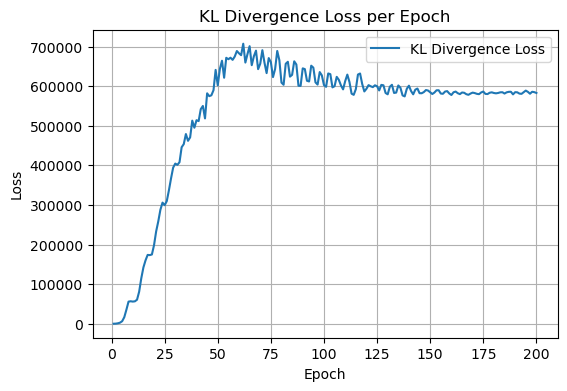

In [229]:
plot_losses(losses, nb_losses, bernoulli_losses, kl_losses)

#### Cluster for VAE + Attention

In [230]:
def plot_clusters_vae_attention(model, X_data):
    model.eval()
    with torch.no_grad():
        _, mu, _, _ = model(X_data)
    mu_np = mu.cpu().numpy()

    adata_latent = sc.AnnData(X=mu_np)
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X")
    sc.tl.umap(adata_latent)
    umap_coords = adata_latent.obsm['X_umap']

    methods = ['leiden', 'louvain']
    resolutions = [0.4, 0.6, 0.8]

    fig, axs = plt.subplots(len(methods), len(resolutions), figsize=(18, 10))
    for i, method in enumerate(methods):
        for j, res in enumerate(resolutions):
            key = f"{method}_r{res}"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            axs[i, j].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
            axs[i, j].set_title(f"{method.title()} (res={res})")
            axs[i, j].set_xlabel("UMAP1")
            axs[i, j].set_ylabel("UMAP2")

    plt.tight_layout()
    plt.show()

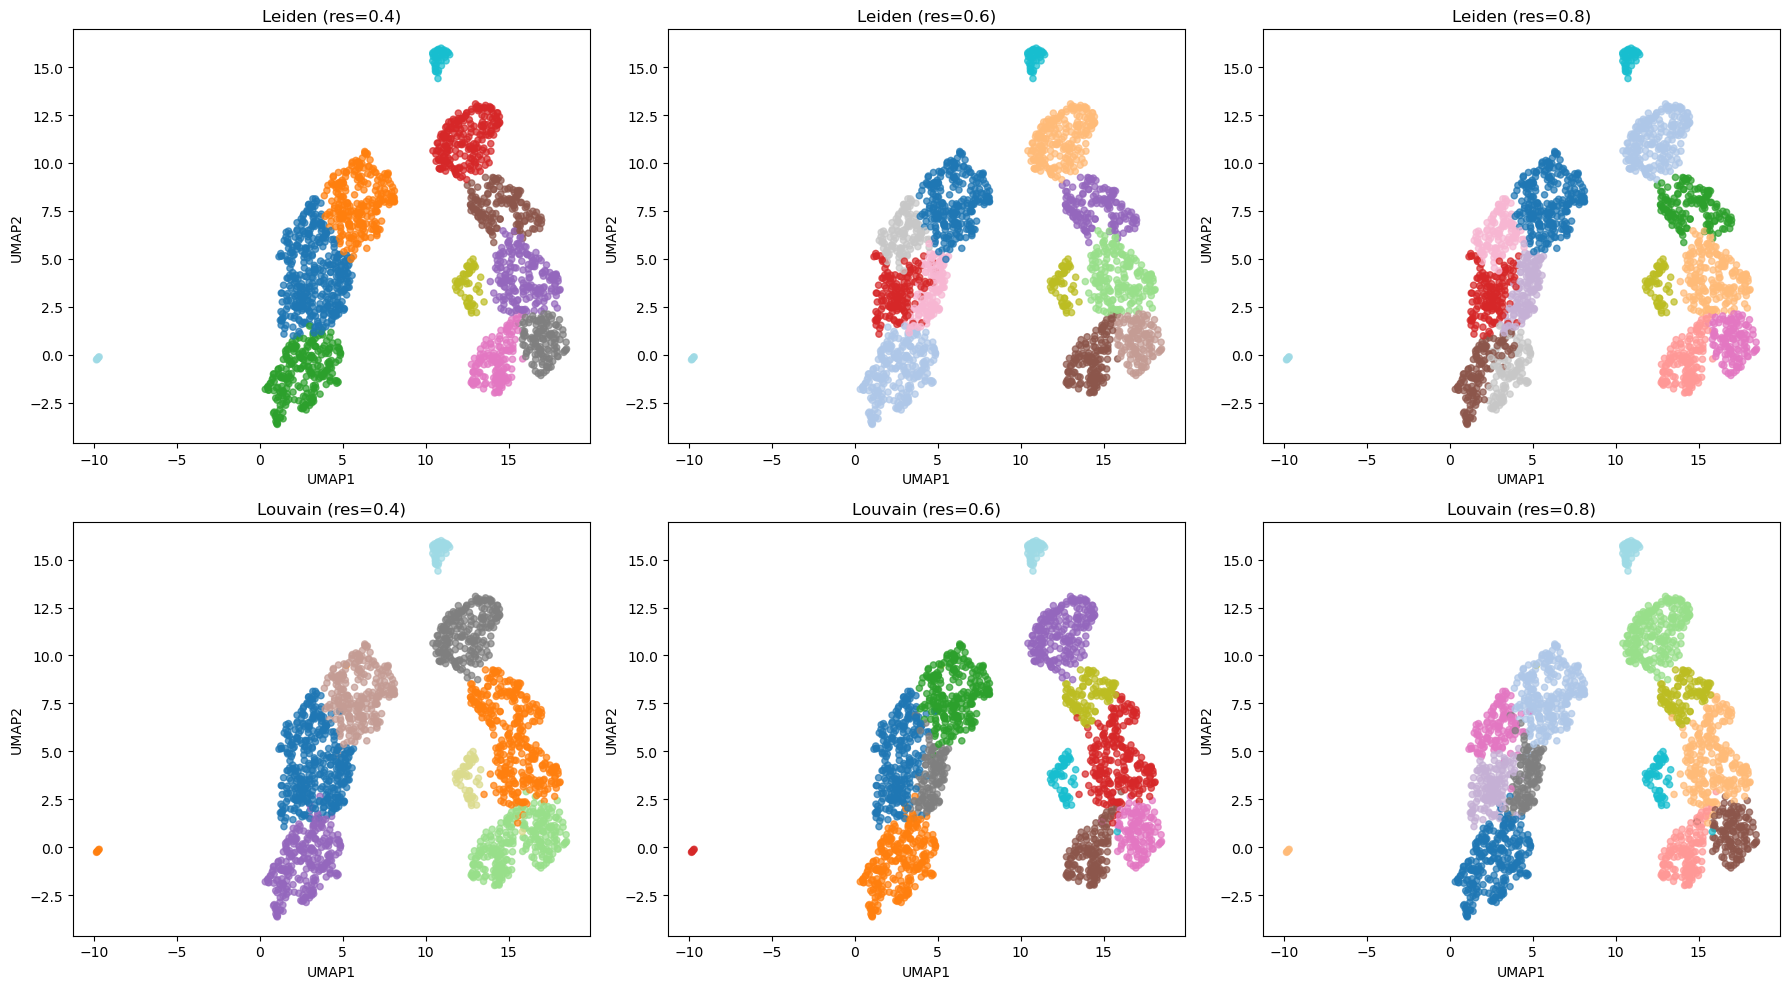

In [231]:
plot_clusters_vae_attention(model_attention, X_data_tensor)


In [263]:
device = next(model_attention.parameters()).device
X_data_tensor_device = X_data_tensor.to(device)
metrics_attention_df = evaluate_model_attention_ordered(model_attention, X_data_tensor_device)
merged_df = pd.merge(metrics_df, metrics_attention_df, on=["Metric", "Method", "Resolution"], how="outer")

In [264]:
merged_df

Metric   Method  Resolution         VAE  \
0                   Silhouette Score   leiden         0.4    0.195177   
1            Calinski-Harabasz Index   leiden         0.4  510.820769   
2                   Silhouette Score   leiden         0.6    0.171419   
3            Calinski-Harabasz Index   leiden         0.6  443.458888   
4                   Silhouette Score   leiden         0.8    0.076785   
5            Calinski-Harabasz Index   leiden         0.8  229.003893   
6                   Silhouette Score  louvain         0.4   -1.000000   
7            Calinski-Harabasz Index  louvain         0.4   -1.000000   
8                   Silhouette Score  louvain         0.6    0.106973   
9            Calinski-Harabasz Index  louvain         0.6  206.088366   
10                  Silhouette Score  louvain         0.8    0.061618   
11           Calinski-Harabasz Index  louvain         0.8  230.627533   
12                               MSE     None         NaN    0.794525   
13               Pearson Correlation     None         NaN    0.000289   
14  Latent Space Normality (p-value)     None         NaN    0.425853   

    VAE+Attention  
0        0.462208  
1     3348.233447  
2        0.435036  
3     3652.384527  
4        0.411317  
5     3600.145376  
6        0.408141  
7     2133.816489  
8        0.390661  
9     1920.285863  
10       0.394807  
11    1912.544419  
12       4.551389  
13      -0.003726  
14       0.029407

### Differential Expression for VAE + Attention

In [267]:
model_attention.eval()
with torch.no_grad():
    x_tensor = torch.Tensor(adata_filtered.X.A if hasattr(adata_filtered.X, "A") else adata_filtered.X).to(device)
    mu, _ = model_attention.encode(x_tensor)
    latent = mu.cpu().numpy()


In [268]:
adata_filtered.obsm["X_latent_attn"] = latent


In [270]:
sc.pp.neighbors(adata_filtered, use_rep="X_latent_attn", n_neighbors=15)
sc.tl.leiden(adata_filtered, resolution=0.6, key_added="leiden_attn_0.6")


In [271]:
sc.tl.rank_genes_groups(
    adata_filtered,
    groupby="leiden_attn_0.6",
    method="wilcoxon",
    use_raw=False
)


### Cluster Interpretation Based on Marker Ranking Plots

| Cluster | Top Marker Genes                            | Probable Cell Type                                | Description |
|---------|---------------------------------------------|---------------------------------------------------|-------------|
| 0       | HLA-DRA, HLA-DRB1, HLA-DPA1, CD74            | Antigen-presenting cells (APCs)                   | MHC class II expression suggests activated microglia or dendritic cells presenting antigens to T cells. Common in glioblastoma immune responses. |
| 1       | S100A9, LYZ, CST3, FCER1G                   | Classical monocytes / myeloid cells               | High expression of lysosomal and inflammatory markers indicates innate immune cells like monocytes infiltrating the tumor. |
| 2       | CCL3, CCL4, GZMB, IFNG, NKG7                | Activated cytotoxic T or NK-like cells            | This cluster shows strong pro-inflammatory and cytotoxic profiles, typical of activated effector immune cells targeting tumor cells. |
| 3       | GNLY, GZMB, PRF1, KLRD1                     | NK cells or cytotoxic T lymphocytes               | Cytolytic gene profile suggests innate lymphoid cells capable of tumor cell killing. |
| 4       | IGHM, CD79A, MS4A1, MZB1                    | B cells / memory B cells                          | Expression of immunoglobulin and BCR-related genes suggests presence of adaptive humoral immune cells in the tumor niche. |
| 5       | JCHAIN, IGHG1, IGKC                         | Plasma cells / antibody-secreting B cells         | High levels of immunoglobulin components suggest these are terminally differentiated B cells involved in antibody production. |
| 6       | HBB, HBA2, AHSP, ALAS2                      | Erythroid lineage                                 | Hemoglobin and erythrocyte genes indicate red blood cells or erythroid precursors, likely due to blood contamination or vascular proximity. |
| 7       | HLA-DRA, CCL3, CCL4, CD74                   | APC-like / microglia                              | Similar to cluster 0, suggests a subpopulation of antigen-presenting microglia with inflammatory chemokine signaling. |
| 8       | PPBP, PF4, ITGA2B                           | Platelets / megakaryocyte-derived elements        | Platelet markers reflect circulating cell fragments, possibly adhered to vasculature in the glioblastoma microenvironment. |
| 9       | CD14, FCN1, LYZ                             | Classical monocytes / TAM precursors              | Indicative of monocytes that may differentiate into tumor-associated macrophages (TAMs), influencing glioma progression. |
| 10      | GNLY, PRF1, GZMB, KLRD1                     | NK cells                                          | Strong cytotoxic gene signature characteristic of natural killer cells. These are key in innate immune surveillance. |
| 11      | ZNF683, TRAC, CCL5, GZMK                    | CD8+ T cells / tissue-resident memory T cells     | Express cytotoxic and tissue-residency genes, suggesting long-term presence in glioma and adaptive immune memory potential. |


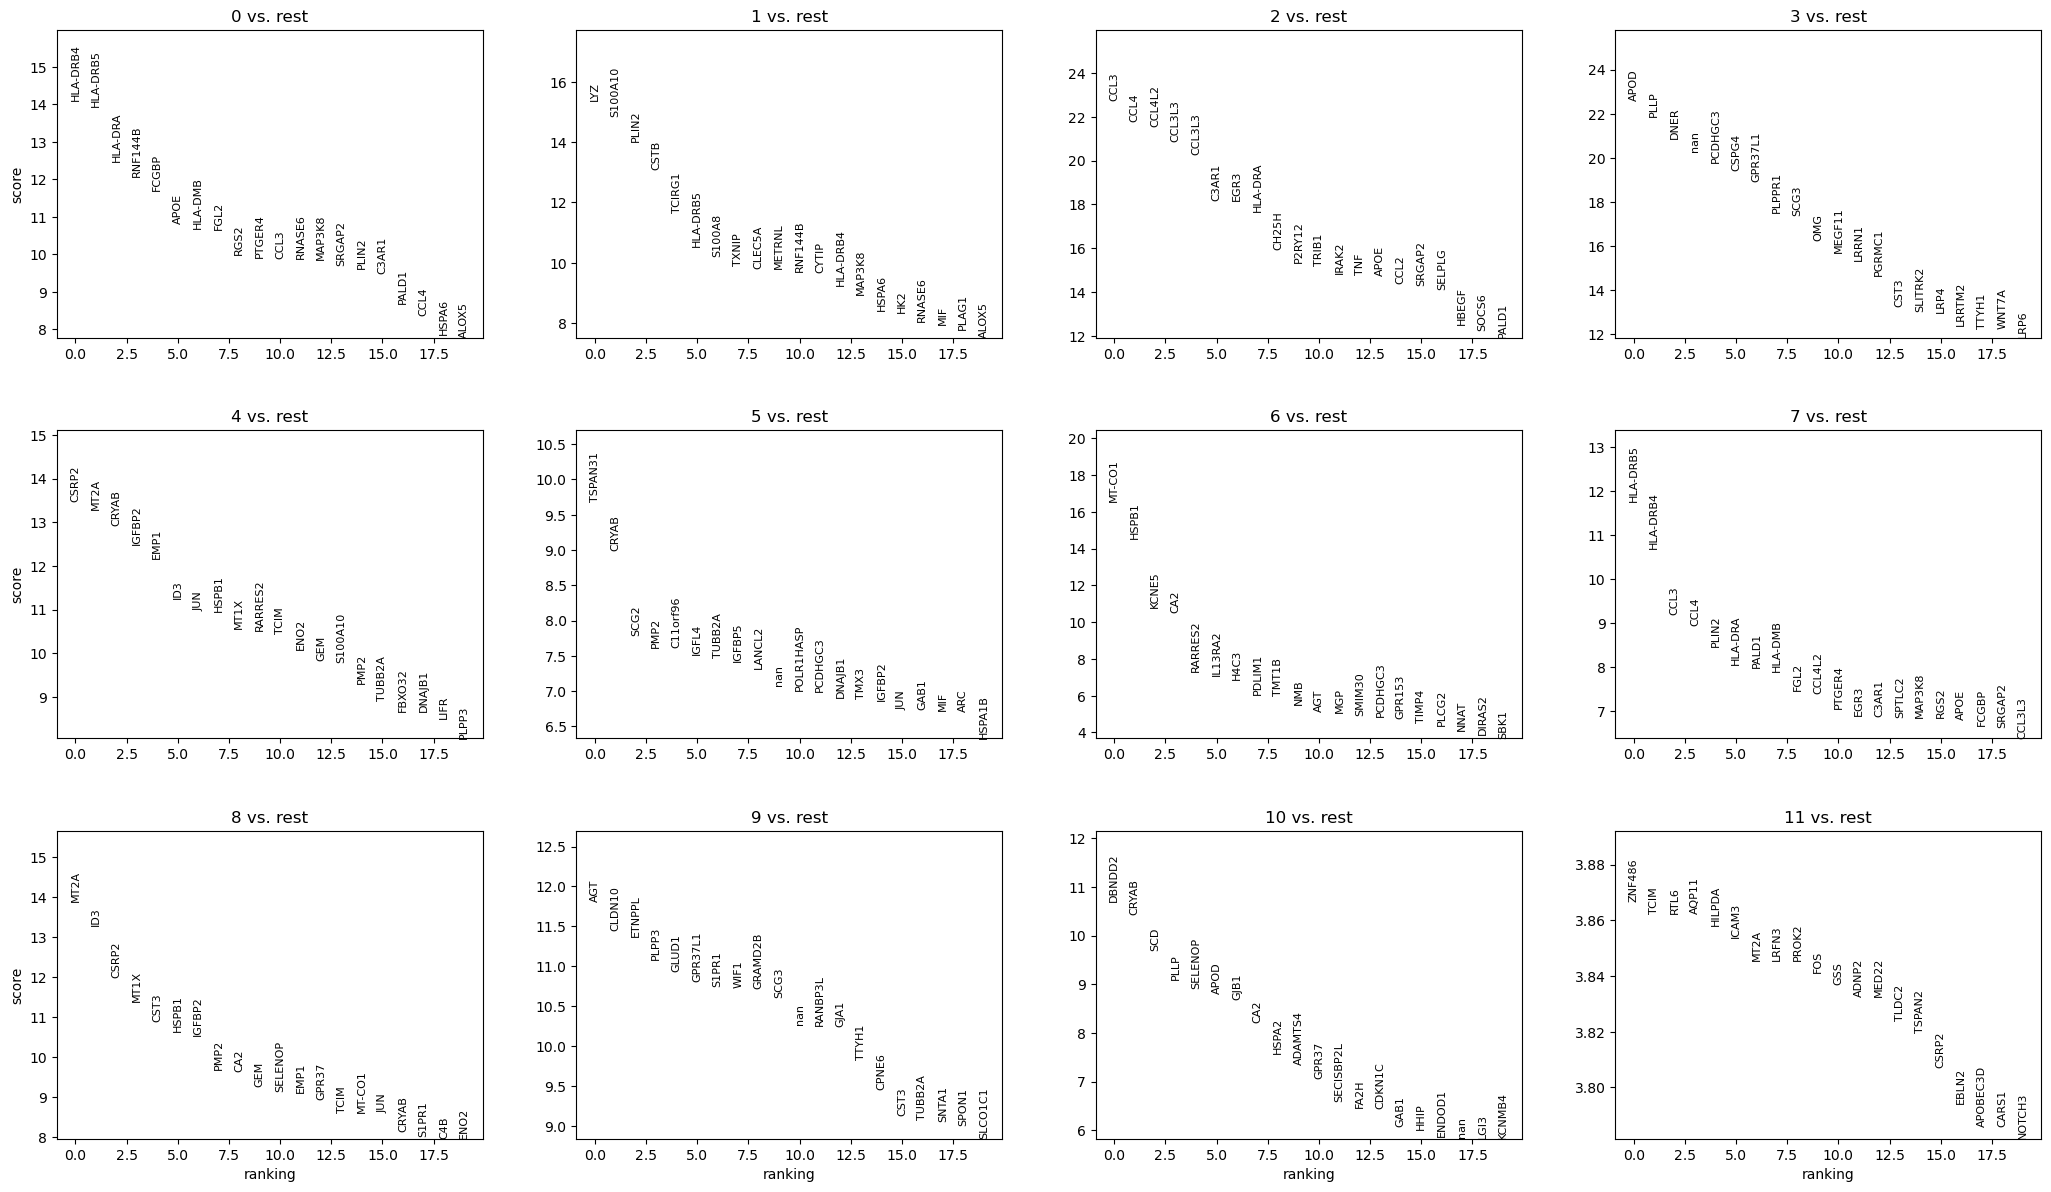

In [273]:
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False, gene_symbols='gene_symbols')


In [275]:
result = adata_filtered.uns['rank_genes_groups']
groups = result['names'].dtype.names

The green vertical lines represent log fold change thresholds (typically at +1 and -1).

The blue horizontal line represents the p-value threshold (typically at p = 0.05, shown as -log10(0.05) on the y-axis).

If a point (gene) is outside these lines, it means:
To the right of the green line (> +1 logFC):
The gene is strongly upregulated in the cluster compared to the others.

To the left of the green line (< -1 logFC):
The gene is strongly downregulated in the cluster compared to the others.

Above the blue line:
The gene is statistically significant, because its p-value is less than 0.05.

So if a gene is:
Beyond the green lines and above the blue line, it's considered both:

Statistically significant

Biologically meaningful (large expression change)

These genes (points) are often colored red in the plot because they are the most relevant for biological interpretation.

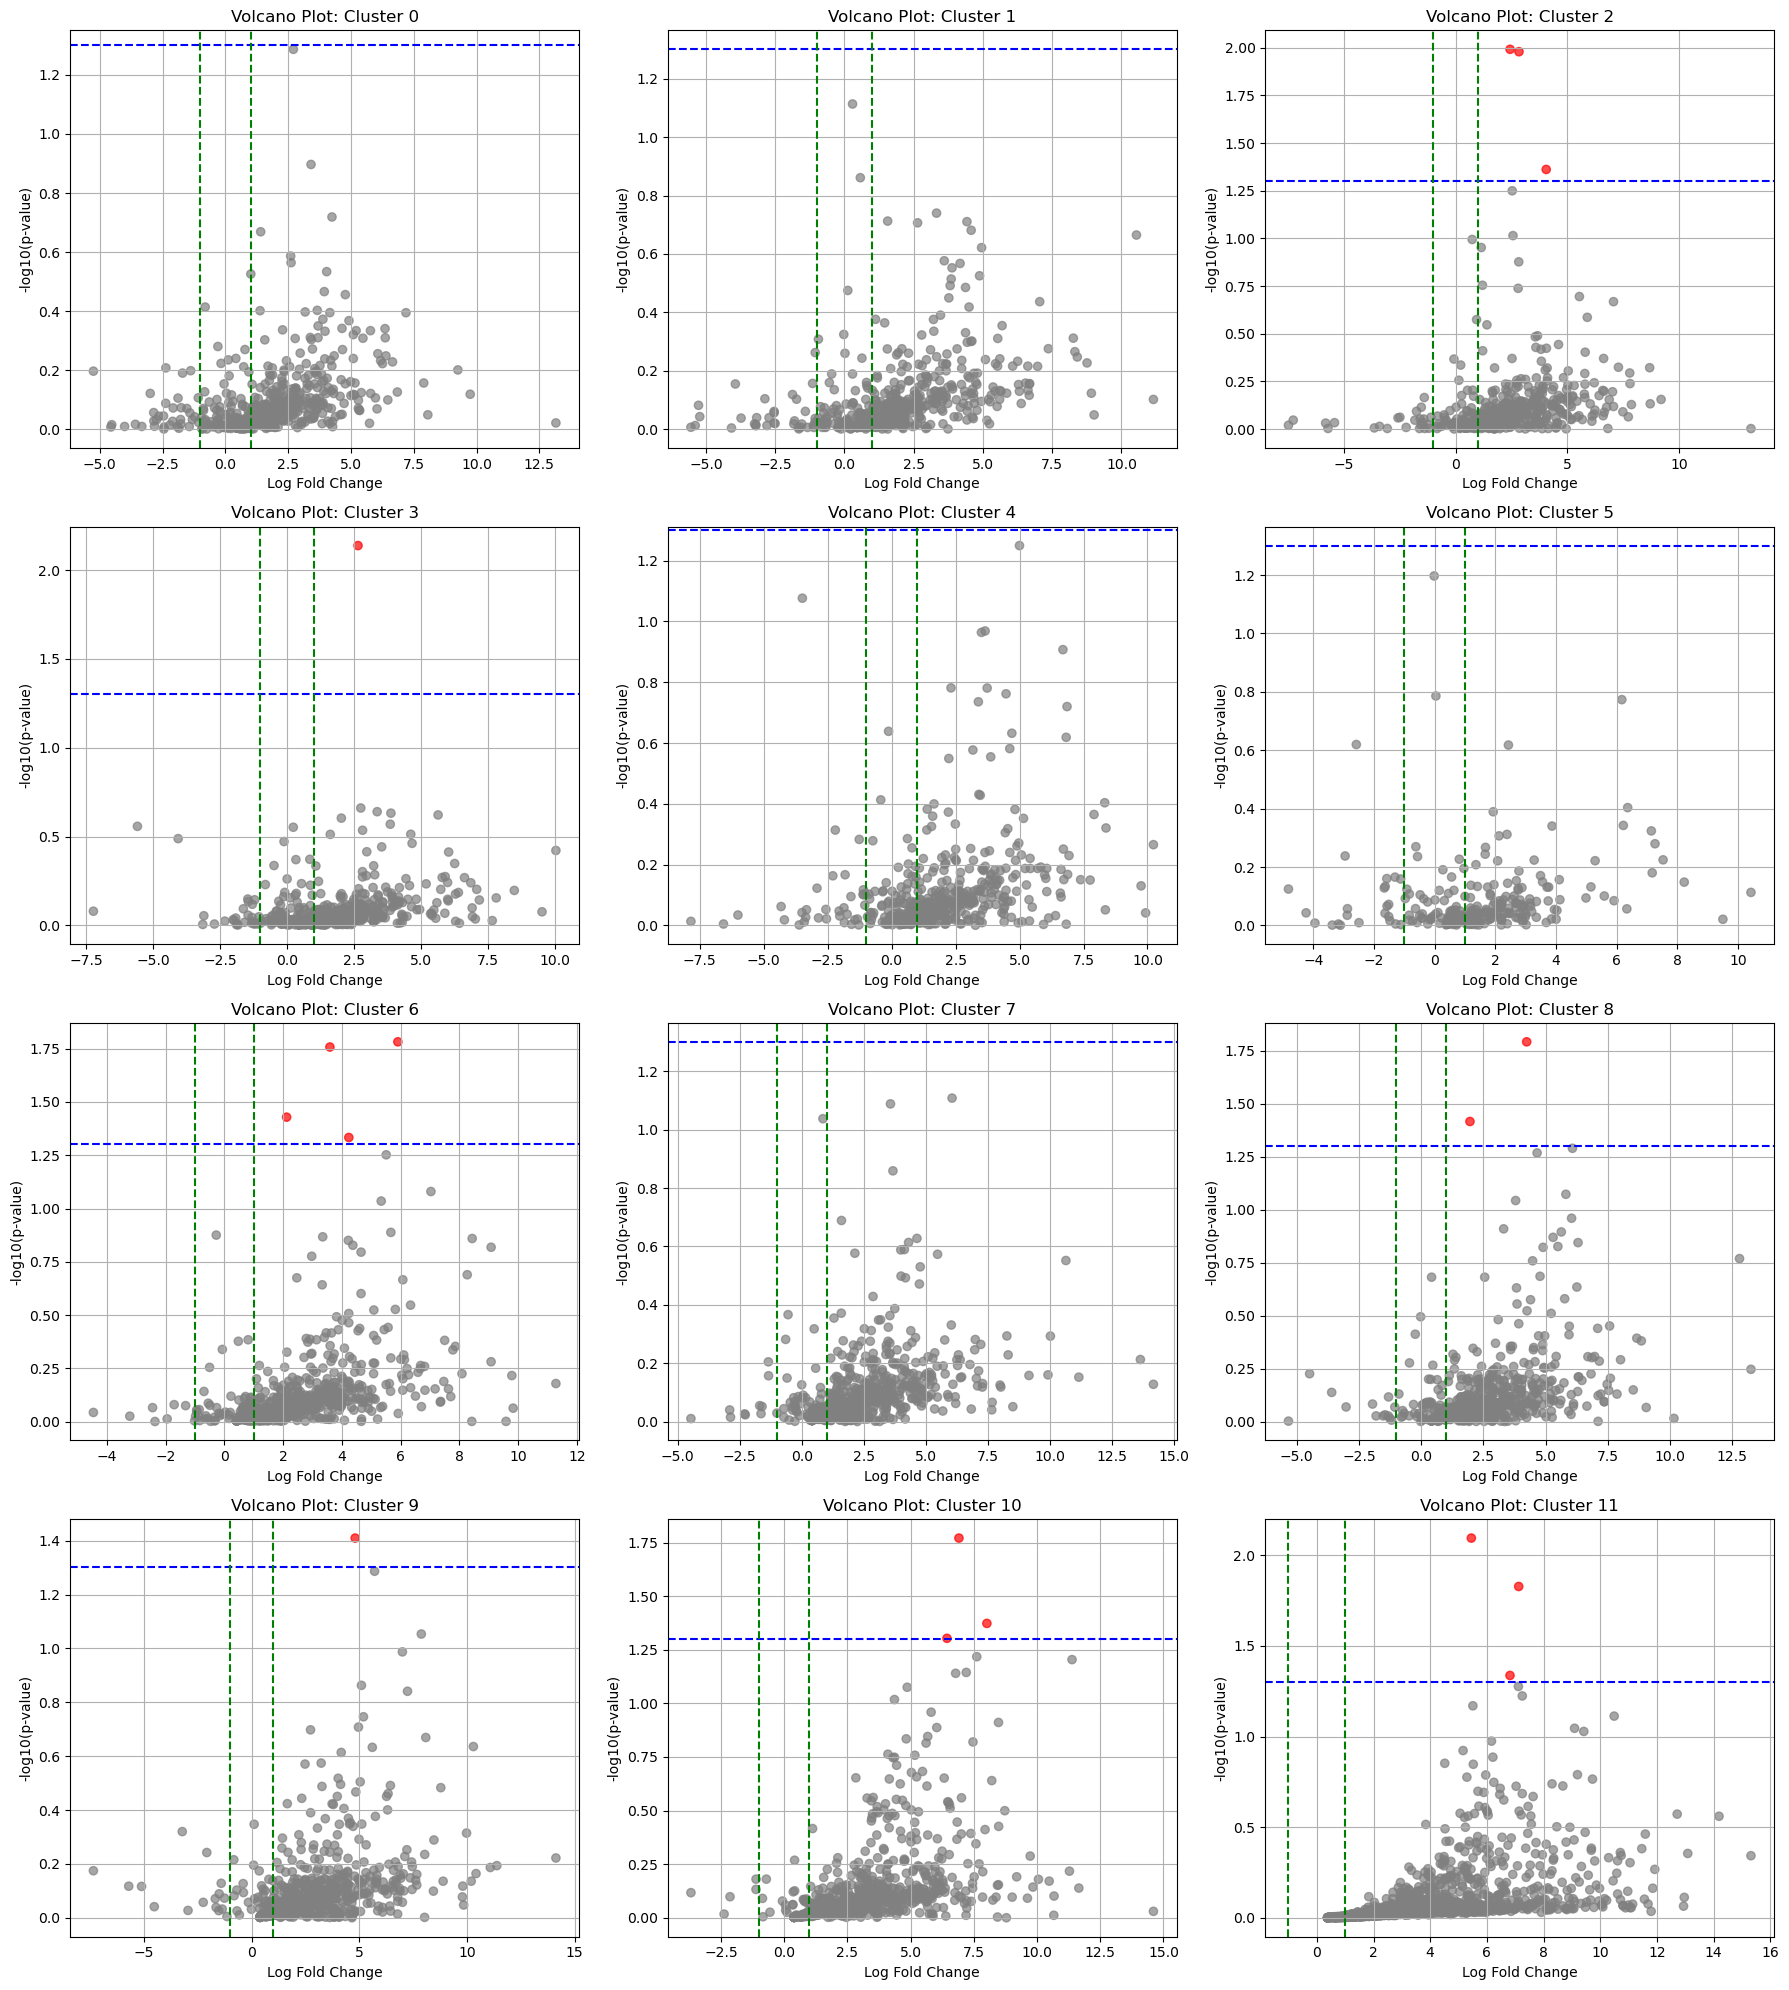

In [276]:
fig, axs = plt.subplots(4, 3, figsize=(18, 20))
axs = axs.flatten()

for i, group in enumerate(groups):
    if i >= len(axs):  
        break

    # Current group data
    names = result['names'][group]
    logfc = result['logfoldchanges'][group]
    pvals = result['pvals'][group]

    if 'gene_symbols' in adata_filtered.var.columns:
        gene_symbols = adata_filtered.var.loc[names, 'gene_symbols'].values
    else:
        gene_symbols = names

    volcano_df = pd.DataFrame({
        'gene': gene_symbols,
        'logFC': logfc,
        'pval': pvals
    })

    volcano_df['neg_log10_pval'] = -np.log10(volcano_df['pval'])
    volcano_df['significant'] = (volcano_df['pval'] < 0.05) & (abs(volcano_df['logFC']) > 1)

    ax = axs[i]
    ax.scatter(volcano_df['logFC'], volcano_df['neg_log10_pval'],
               c=volcano_df['significant'].map({True: 'red', False: 'gray'}),
               alpha=0.7)
    ax.set_title(f'Volcano Plot: Cluster {group}')
    ax.set_xlabel('Log Fold Change')
    ax.set_ylabel('-log10(p-value)')
    ax.axhline(-np.log10(0.05), color='blue', linestyle='--')
    ax.axvline(1, color='green', linestyle='--')
    ax.axvline(-1, color='green', linestyle='--')
    ax.grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## VAE + GAT

We calculate the expression Graph 

In [360]:
X = adata_filtered.X
X_array = X.toarray() if hasattr(X, 'toarray') else X  

# CReate the graph using k-NN
k = 10
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_array)
distances, indices = nbrs.kneighbors(X_array)


In [361]:
edges = []
n_cells = X_array.shape[0]

for i in range(n_cells):
    for j in indices[i][1:]:  #not self loop
        edges.append([i, j])
        edges.append([j, i])  # driven graph

edge_index_cells = torch.tensor(edges, dtype=torch.long).T  # shape (2, num_edges)

print(f" Número de aristas: {edge_index_cells.shape[1]}")
print(f" Número de células (nodos): {n_cells}")

 Número de aristas: 36460
 Número de células (nodos): 1823


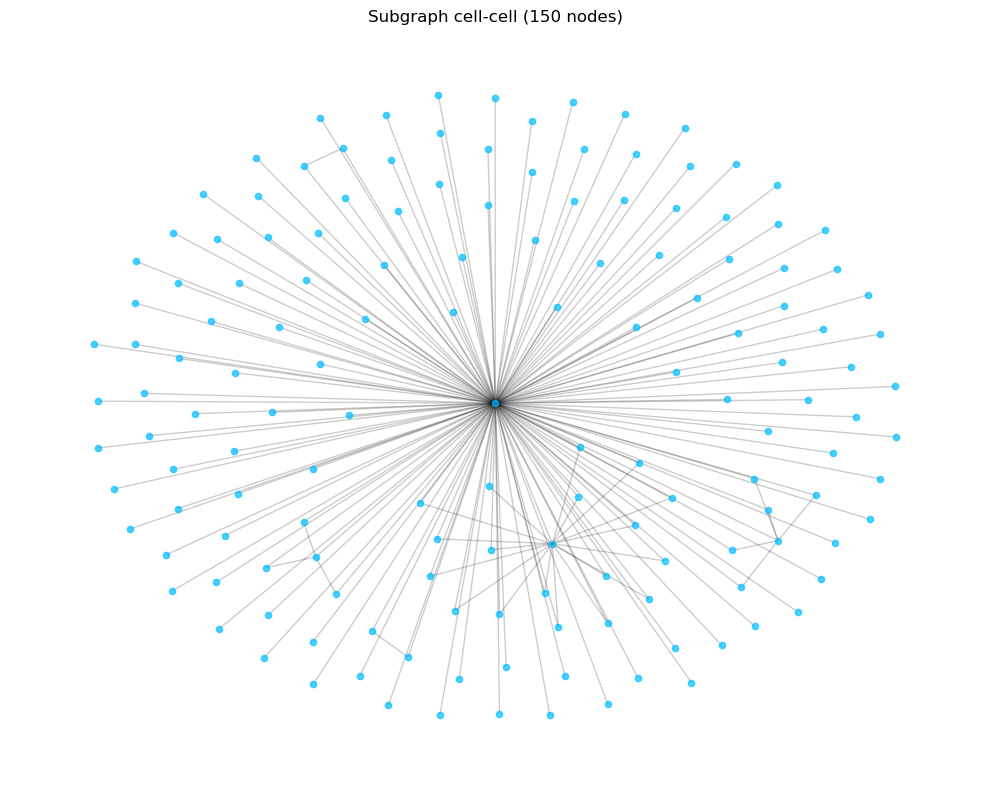

In [280]:
G = nx.Graph()
edges = edge_index_cells.T.tolist()
G.add_edges_from(edges)

# subgraph random sampling
sample_nodes = random.sample(list(G.nodes), 150)
subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=20, node_color='deepskyblue', alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
plt.title("Subgraph cell-cell (150 nodes)")
plt.axis('off')
plt.tight_layout()
plt.show()

### Hyperparametrization of VAE + GAT

In [ ]:
class VAE_GAT_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1, num_heads=2):
        super(VAE_GAT_Cell, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        p0 = torch.sigmoid(self.fc_p0(h))
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        mu, log_var, p0 = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, p0
    

In [ ]:
def zinb_loss(recon_x, x, mu, log_var, p0, beta=1.0, theta=1.0):
    if x.is_sparse:
        x = x.to_dense()
    if recon_x.is_sparse:
        recon_x = recon_x.to_dense()
    x = torch.abs(x)
    recon_x = torch.abs(recon_x)
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)
    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) +
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))
    p0 = p0.expand(x.size(0), x.size(1))
    p0 = torch.clamp(p0, min=1e-5, max=1 - 1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))
    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
latent_dims = [32, 64]
hidden_dims = [128, 256]
dropout_rates = [0.1, 0.3]
betas = [0.1, 1.0]
num_epochs = 200

param_grid = list(product(latent_dims, hidden_dims, dropout_rates, betas))
results = []

# Training for each combination
for latent_dim, hidden_dim, dropout_rate, beta in tqdm(param_grid, desc="Grid Search"):
    set_seed(42)

    model = VAE_GAT_Cell(input_dim=X_tensor.shape[1],
                         hidden_dim=hidden_dim,
                         latent_dim=latent_dim,
                         dropout_rate=dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
        loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_x, X_tensor, mu, log_var, p0, beta=beta)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
        mu_np = mu.numpy()
        pearson_corr = np.corrcoef(X_tensor.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
        kl_div = kl_loss.item()

        umap_embeds = umap.UMAP(n_components=2, random_state=42).fit_transform(mu_np)
        labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(umap_embeds)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        silhouette = silhouette_score(umap_embeds, labels) if n_clusters > 1 else -1
        calinski = calinski_harabasz_score(umap_embeds, labels) if n_clusters > 1 else -1

    results.append({
        'latent_dim': latent_dim,
        'hidden_dim': hidden_dim,
        'dropout_rate': dropout_rate,
        'beta': beta,
        'pearson_corr': pearson_corr,
        'silhouette': silhouette,
        'calinski': calinski,
        'kl_divergence': kl_div
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["silhouette", "calinski", "pearson_corr"], ascending=False)
print(results_df.head(10))

Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:   6%|▋         | 1/16 [02:07<31:56, 127.74s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  12%|█▎        | 2/16 [04:08<28:54, 123.91s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  19%|█▉        | 3/16 [06:11<26:40, 123.08s/it]c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Grid Search:  25%|██▌       | 4/16 [0

    latent_dim  hidden_dim  dropout_rate  beta  pearson_corr  silhouette  \
14          64         256           0.3   0.1      0.000148    0.962478   
15          64         256           0.3   1.0      0.000132    0.948041   
4           32         256           0.1   0.1     -0.000111    0.867644   
11          64         128           0.3   1.0     -0.000403    0.828804   
2           32         128           0.3   0.1      0.000049    0.752601   
5           32         256           0.1   1.0     -0.000075    0.547024   
12          64         256           0.1   0.1     -0.001432    0.385074   
1           32         128           0.1   1.0     -0.001508    0.363834   
7           32         256           0.3   1.0     -0.001574    0.198862   
13          64         256           0.1   1.0      0.000087    0.195343   

         calinski  kl_divergence  
14  417077.597154   1.591323e+07  
15  132579.796732   1.361510e+06  
4     4403.134182   2.890908e+06  
11   15216.441208   4.1

In [226]:
results_df

latent_dim  hidden_dim  dropout_rate  beta  pearson_corr  silhouette  \
14          64         256           0.3   0.1      0.000148    0.962478   
15          64         256           0.3   1.0      0.000132    0.948041   
4           32         256           0.1   0.1     -0.000111    0.867644   
11          64         128           0.3   1.0     -0.000403    0.828804   
2           32         128           0.3   0.1      0.000049    0.752601   
5           32         256           0.1   1.0     -0.000075    0.547024   
12          64         256           0.1   0.1     -0.001432    0.385074   
1           32         128           0.1   1.0     -0.001508    0.363834   
7           32         256           0.3   1.0     -0.001574    0.198862   
13          64         256           0.1   1.0      0.000087    0.195343   
8           64         128           0.1   0.1      0.001138    0.088228   
9           64         128           0.1   1.0     -0.000162    0.034470   
3           32         128           0.3   1.0     -0.000410    0.015829   
6           32         256           0.3   0.1      0.000628    0.006562   
10          64         128           0.3   0.1     -0.001180   -0.006513   
0           32         128           0.1   0.1      0.003605   -0.314394   

         calinski  kl_divergence  
14  417077.597154   1.591323e+07  
15  132579.796732   1.361510e+06  
4     4403.134182   2.890908e+06  
11   15216.441208   4.112711e+05  
2    17909.392912   6.680801e+05  
5    25669.620124   1.265968e+06  
12    1874.009473   1.823830e+06  
1      696.617386   6.159973e+04  
7      743.364529   2.634128e+05  
13     938.828025   1.018689e+06  
8      636.894494   3.178297e+05  
9      760.341408   3.081613e+05  
3      960.967203   1.860802e+05  
6      500.019505   2.328310e+06  
10     296.436004   1.937551e+05  
0       70.165057   1.829032e+05

#### Model Defined VAE + GAT

In [363]:
n_genes = adata_filtered.shape[1]  # columns
input_dim = n_genes
hidden_dim = 256
latent_dim = 64 #latent dimension
learning_rate = 1e-3
num_epochs = 200
X_data = adata_filtered.X  
X = torch.FloatTensor(X_data)
X_tensor = torch.FloatTensor(adata_filtered.X)

In [364]:
class VAE_GAT_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout_rate=0.3, num_heads=2):
        super(VAE_GAT_Cell, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_p0 = nn.Linear(hidden_dim, input_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        h = F.elu(self.gat1(x, edge_index))
        h = self.dropout(h)
        h = F.elu(self.gat2(h, edge_index))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        p0 = torch.sigmoid(self.fc_p0(h))
        return mu, log_var, p0

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x, edge_index):
        mu, log_var, p0 = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, p0


In [365]:
def zinb_loss(recon_x, x, mu, log_var, p0, beta=0.1, theta=1.0):
    x = x.to_dense() if x.is_sparse else x
    recon_x = recon_x.to_dense() if recon_x.is_sparse else recon_x
    x = torch.abs(x)
    recon_x = torch.abs(recon_x)
    theta_tensor = torch.tensor(theta, dtype=x.dtype, device=x.device)
    theta_tensor = torch.clamp(theta_tensor, min=1e-6, max=1e3)

    nb_loss = -torch.sum(torch.lgamma(x + theta_tensor) - torch.lgamma(x + 1) - torch.lgamma(theta_tensor) +
                         x * torch.log(recon_x + 1e-8) + theta_tensor * torch.log(theta_tensor / (recon_x + 1e-8)))
    p0 = torch.clamp(p0.expand(x.size(0), x.size(1)), min=1e-5, max=1 - 1e-5)
    bernoulli_loss = -torch.sum(x * torch.log(1 - p0 + 1e-8) + (1 - x) * torch.log(p0 + 1e-8))
    mu = torch.clamp(mu, min=-10, max=10)
    log_var = torch.clamp(log_var, min=-10, max=10)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = nb_loss + bernoulli_loss + beta * kl_loss
    return total_loss, nb_loss, bernoulli_loss, kl_loss

In [369]:
model = VAE_GAT_Cell(input_dim=X_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses, nb_losses, bernoulli_losses, kl_losses = [], [], [], []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    recon_x, mu, log_var, p0 = model(X_tensor, edge_index_cells)
    loss, nb_loss, bernoulli_loss, kl_loss = zinb_loss(recon_x, X_tensor, mu, log_var, p0, beta=0.1)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    nb_losses.append(nb_loss.item())
    bernoulli_losses.append(bernoulli_loss.item())
    kl_losses.append(kl_loss.item())

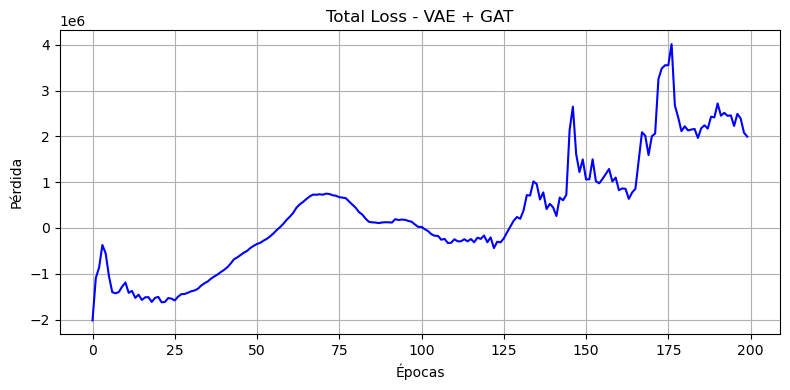

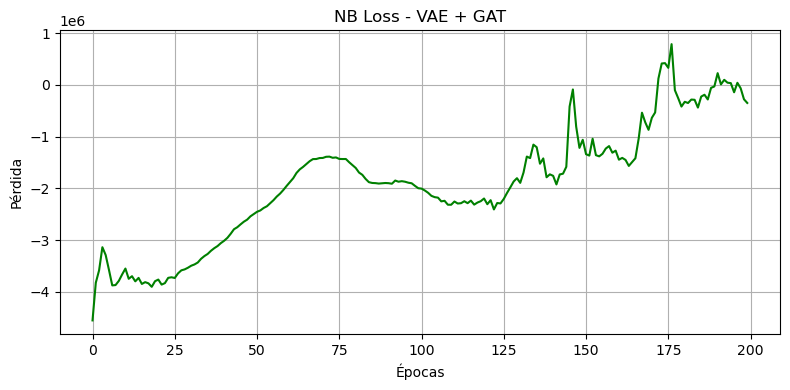

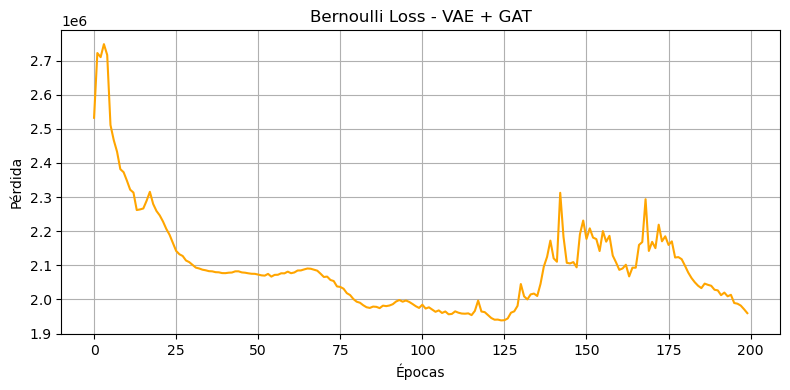

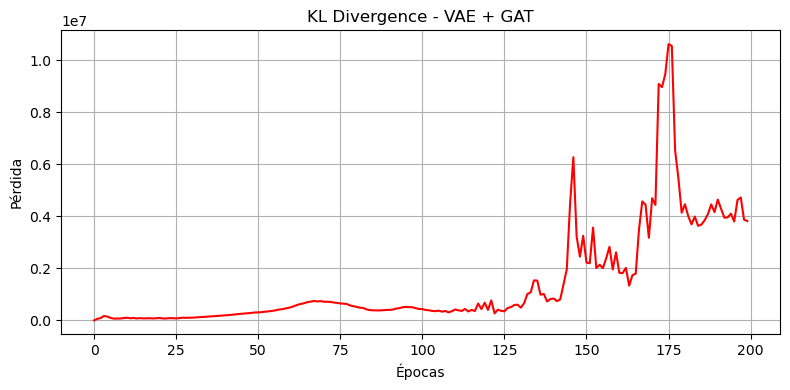

In [236]:
# Total Loss
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Total Loss', color='blue')
plt.title("Total Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# NB Loss
plt.figure(figsize=(8, 4))
plt.plot(nb_losses, label='NB Loss', color='green')
plt.title("NB Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bernoulli Loss
plt.figure(figsize=(8, 4))
plt.plot(bernoulli_losses, label='Bernoulli Loss', color='orange')
plt.title("Bernoulli Loss - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

# KL Loss
plt.figure(figsize=(8, 4))
plt.plot(kl_losses, label='KL Loss', color='red')
plt.title("KL Divergence - VAE + GAT")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()


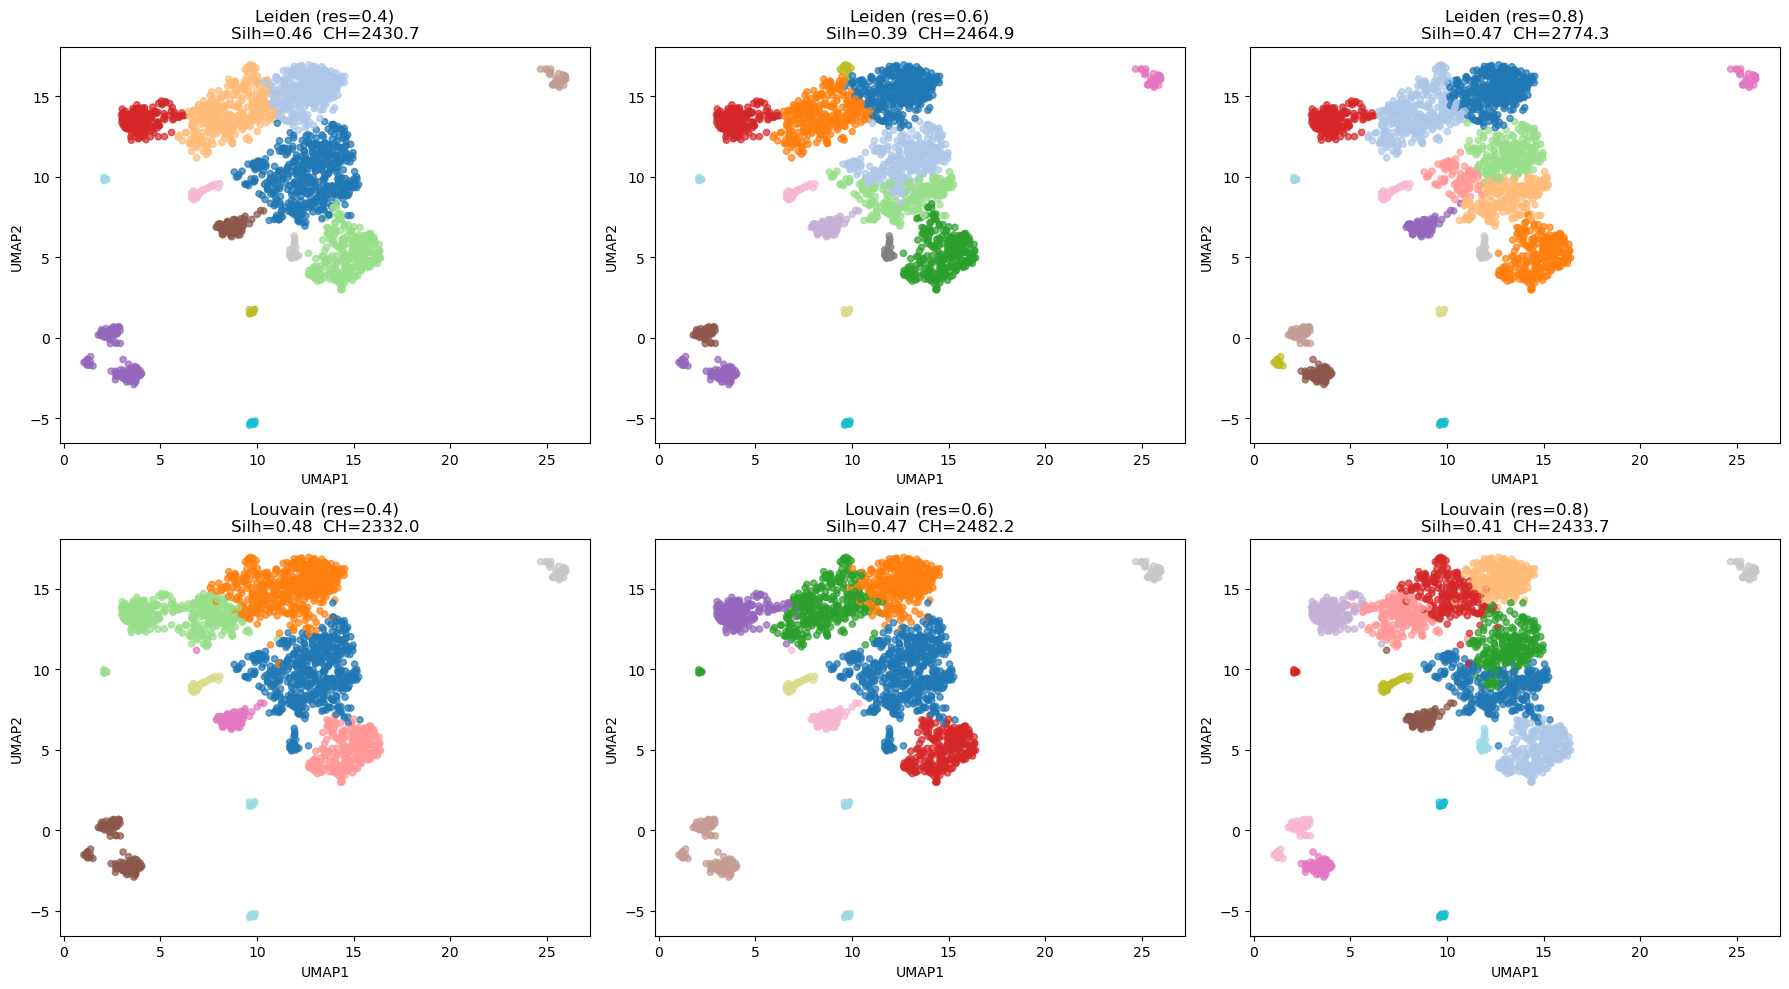

In [370]:
adata_latent = sc.AnnData(X=mu.detach().cpu().numpy())
sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
sc.tl.umap(adata_latent)
umap_coords = adata_latent.obsm['X_umap']

resolutions = [0.4, 0.6, 0.8]
methods = ['leiden', 'louvain']
clustering_results = []

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
i = 0

for method in methods:
    for res in resolutions:
        key = f"{method}_r"
        if method == 'leiden':
            sc.tl.leiden(adata_latent, resolution=res, key_added=key)
        else:
            sc.tl.louvain(adata_latent, resolution=res, key_added=key)

        labels = adata_latent.obs[key].astype(int).values
        n_clusters = len(set(labels))
        silh = silhouette_score(umap_coords, labels) if n_clusters > 1 else -1
        ch = calinski_harabasz_score(umap_coords, labels) if n_clusters > 1 else -1

        clustering_results.append({
            'method': method,
            'resolution': res,
            'n_clusters': n_clusters,
            'silhouette': silh,
            'calinski_harabasz': ch
        })

        axs[i].scatter(umap_coords[:, 0], umap_coords[:, 1], c=labels, cmap='tab20', s=20, alpha=0.7)
        axs[i].set_title(f"{method.title()} (res={res})\nSilh={silh:.2f}  CH={ch:.1f}")
        axs[i].set_xlabel("UMAP1")
        axs[i].set_ylabel("UMAP2")
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
# recon_np = recon_x.detach().numpy()
# pearson_corr = np.corrcoef(X_tensor.numpy().flatten(), recon_np.flatten())[0, 1]
# kl_div = kl_loss.item()

# metrics_df = pd.DataFrame({
#     'Metric': ['Pearson Corr', 'Silhouette Score', 'Calinski-Harabasz', 'KL Divergence'],
#     'VAE + GAT': [pearson_corr, silh, ch, kl_div]
# })

In [ ]:
# pd.set_option('display.float_format', '{:.6f}'.format)
# metrics_df

In [ ]:
def evaluate_model_vae_gat(model, X_data, edge_index):
    model.eval()
    with torch.no_grad():
        recon, mu, log_var, _ = model(X_data, edge_index)
    mu_np = mu.cpu().numpy()
    X_np = X_data.cpu().numpy()
    recon_np = recon.cpu().numpy()

    mse = mean_squared_error(X_np.flatten(), recon_np.flatten())
    pearson_corr = pearsonr(X_np.flatten(), recon_np.flatten())[0]
    latent_normality_pval = normaltest(mu_np, axis=0).pvalue.mean()

    adata_latent = sc.AnnData(X=mu_np)
    sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X")
    sc.tl.umap(adata_latent)

    metrics = []
    methods = ['leiden', 'louvain']
    resolutions = [0.4, 0.6, 0.8]

    for method in methods:
        for res in resolutions:
            key = f"{method}_r{res}"
            if method == 'leiden':
                sc.tl.leiden(adata_latent, resolution=res, key_added=key)
            else:
                sc.tl.louvain(adata_latent, resolution=res, key_added=key)

            labels = adata_latent.obs[key].astype(int).values
            if len(set(labels)) > 1:
                silh = silhouette_score(adata_latent.obsm['X_umap'], labels)
                ch = calinski_harabasz_score(adata_latent.obsm['X_umap'], labels)
            else:
                silh, ch = np.nan, np.nan

            metrics.append({'Metric': 'Silhouette Score', 'Value': silh, 'Method': method, 'Resolution': res})
            metrics.append({'Metric': 'Calinski-Harabasz Index', 'Value': ch, 'Method': method, 'Resolution': res})

    metrics.extend([
        {'Metric': 'MSE', 'Value': mse, 'Method': np.nan, 'Resolution': np.nan},
        {'Metric': 'Pearson Correlation', 'Value': pearson_corr, 'Method': np.nan, 'Resolution': np.nan},
        {'Metric': 'Latent Space Normality (p-value)', 'Value': latent_normality_pval, 'Method': np.nan, 'Resolution': np.nan}
    ])

    df_metrics = pd.DataFrame(metrics)

    metric_order = [
        ('Silhouette Score', 'leiden', 0.4),
        ('Calinski-Harabasz Index', 'leiden', 0.4),
        ('Silhouette Score', 'leiden', 0.6),
        ('Calinski-Harabasz Index', 'leiden', 0.6),
        ('Silhouette Score', 'leiden', 0.8),
        ('Calinski-Harabasz Index', 'leiden', 0.8),
        ('Silhouette Score', 'louvain', 0.4),
        ('Calinski-Harabasz Index', 'louvain', 0.4),
        ('Silhouette Score', 'louvain', 0.6),
        ('Calinski-Harabasz Index', 'louvain', 0.6),
        ('Silhouette Score', 'louvain', 0.8),
        ('Calinski-Harabasz Index', 'louvain', 0.8),
        ('MSE', np.nan, np.nan),
        ('Pearson Correlation', np.nan, np.nan),
        ('Latent Space Normality (p-value)', np.nan, np.nan)
    ]

    ordered_df = pd.DataFrame()
    for metric, method, res in metric_order:
        if pd.isna(method) and pd.isna(res):
            row = df_metrics[(df_metrics['Metric'] == metric) & (df_metrics['Method'].isna()) & (df_metrics['Resolution'].isna())]
        else:
            row = df_metrics[(df_metrics['Metric'] == metric) & (df_metrics['Method'] == method) & (df_metrics['Resolution'] == res)]
        ordered_df = pd.concat([ordered_df, row], ignore_index=True)

    return ordered_df.reset_index(drop=True)

In [372]:
metrics_gat_df = evaluate_model_vae_gat(model, X_tensor, edge_index_cells)
final_df = merged_df.merge(metrics_gat_df, on=["Metric", "Method", "Resolution"], how="outer")

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
final_df

Metric   Method  Resolution         VAE  \
0                   Silhouette Score   leiden         0.4    0.195177   
1            Calinski-Harabasz Index   leiden         0.4  510.820769   
2                   Silhouette Score   leiden         0.6    0.171419   
3            Calinski-Harabasz Index   leiden         0.6  443.458888   
4                   Silhouette Score   leiden         0.8    0.076785   
5            Calinski-Harabasz Index   leiden         0.8  229.003893   
6                   Silhouette Score  louvain         0.4   -1.000000   
7            Calinski-Harabasz Index  louvain         0.4   -1.000000   
8                   Silhouette Score  louvain         0.6    0.106973   
9            Calinski-Harabasz Index  louvain         0.6  206.088366   
10                  Silhouette Score  louvain         0.8    0.061618   
11           Calinski-Harabasz Index  louvain         0.8  230.627533   
12                               MSE     None         NaN    0.794525   
13               Pearson Correlation     None         NaN    0.000289   
14  Latent Space Normality (p-value)     None         NaN    0.425853   

    VAE+Attention      VAE+GAT  
0        0.462208     0.459771  
1     3348.233447  2430.691527  
2        0.435036     0.394551  
3     3652.384527  2464.879944  
4        0.411317     0.471954  
5     3600.145376  2774.322012  
6        0.408141     0.477607  
7     2133.816489  2332.017864  
8        0.390661     0.470149  
9     1920.285863  2482.156713  
10       0.394807     0.405119  
11    1912.544419  2433.678608  
12       4.551389     2.381168  
13      -0.003726     0.090071  
14       0.029407     0.000477

### Differential Expression for VAE + GAT

In [ ]:
mu_np = mu.detach().cpu().numpy()
adata_latent = sc.AnnData(X=mu_np)

In [ ]:
sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep='X')
sc.tl.umap(adata_latent)

In [ ]:
sc.tl.leiden(adata_latent, resolution=0.6, key_added='leiden_gat_0.6')
#Assign Labels
adata_filtered.obs['leiden_gat_0.6'] = adata_latent.obs['leiden_gat_0.6'].values


In [ ]:
sc.tl.rank_genes_groups( #apply DE
    adata_filtered,
    groupby='leiden_gat_0.6',
    method='wilcoxon',
    use_raw=False,
    key_added='rank_genes_gat'
)


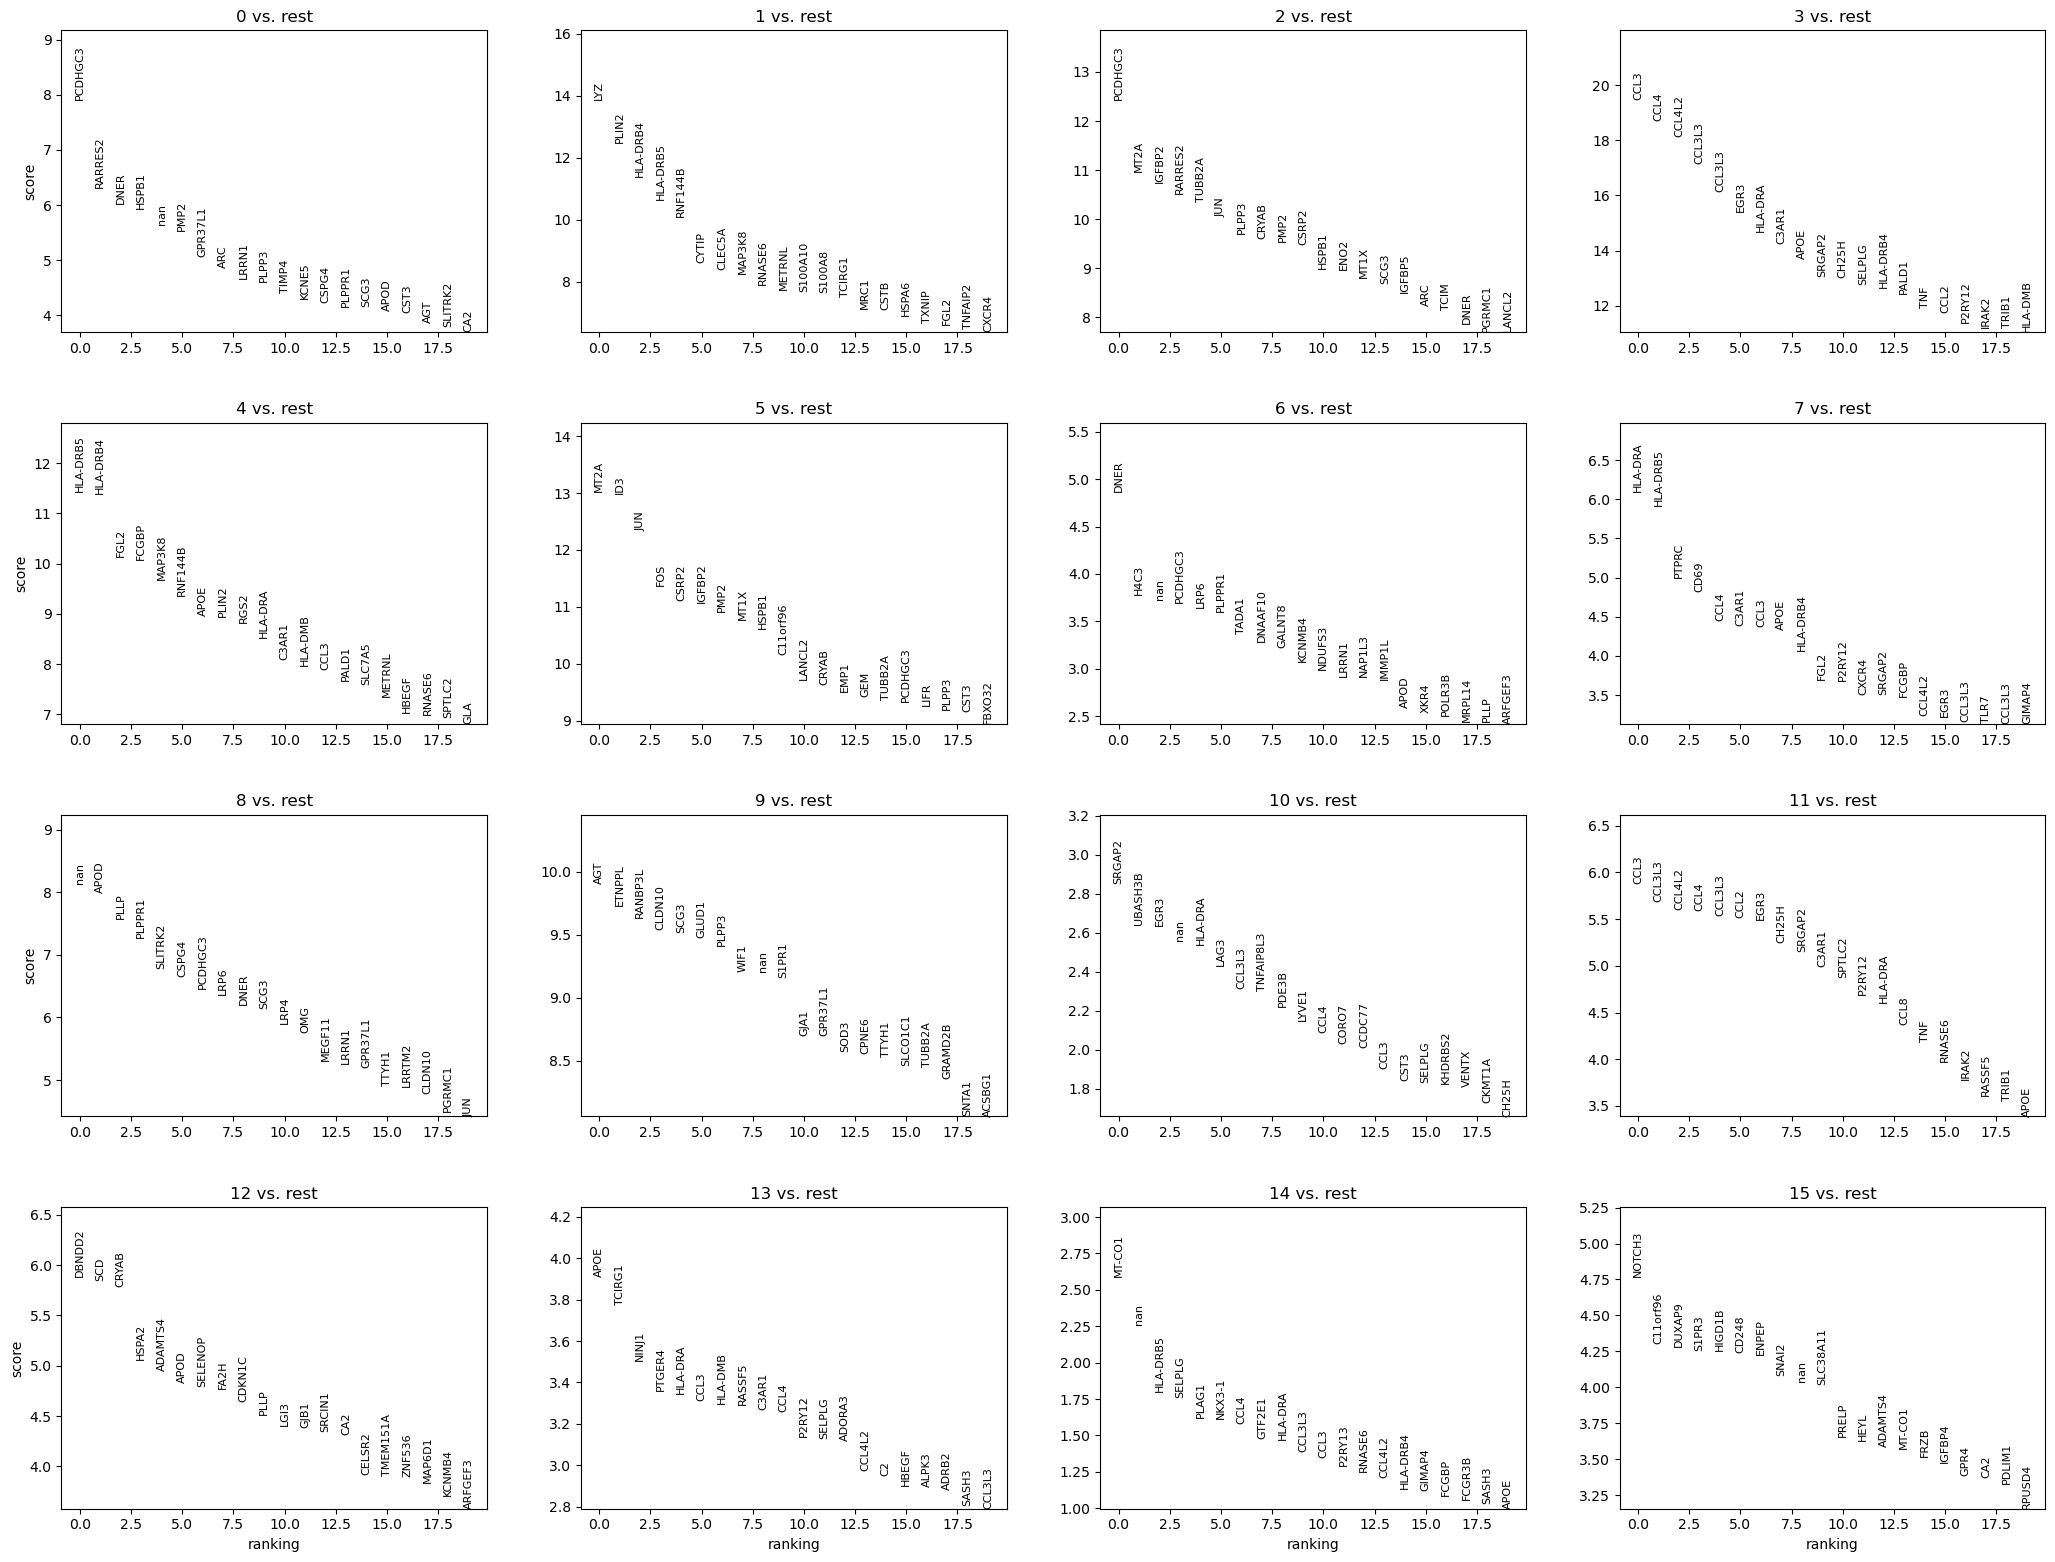

In [ ]:
sc.pl.rank_genes_groups(
    adata_filtered,
    n_genes=20,
    sharey=False,
    gene_symbols='gene_symbols',
    key='rank_genes_gat'
)


volvano plot

In [391]:
key_added='rank_genes_gat'


#### Cluster Summary with Biological Interpretation



| Cluster | Top Marker Genes                     | Probable Cell Type                         | Description |
|---------|--------------------------------------|--------------------------------------------|-------------|
| 0       | TRBC2, TRAC, CD3D, CD3E              | T cells (naive/early activated)            | Classic TCR and CD3 markers suggest infiltrating T lymphocytes, possibly CD4+ T cells, involved in immune surveillance or early anti-tumor responses. |
| 1       | LTB, GIMAP7, CD7, IL32               | Activated T cells / T memory               | These markers point to a more activated or memory-like T cell state, indicating tumor-infiltrating lymphocytes (TILs) with potential immune memory against glioblastoma antigens. |
| 2       | CD8A, GZMA, PRF1, NKG7               | Cytotoxic T lymphocytes (CTLs)             | Express cytolytic granules; likely active CD8+ T cells, attempting to eliminate tumor cells. May also reflect exhaustion phenotype in late-stage tumors. |
| 3       | CCL3, CCL4, GZMB, IFNG               | Highly activated CTLs / NK-like T cells    | Pro-inflammatory chemokines and cytotoxic genes suggest strong anti-tumor effector activity. Could be hybrid T/NK cells in the glioblastoma TME. |
| 4       | HLA-DRA, CD74, H2-Aa, CCL17          | Antigen-presenting cells (microglia/macrophages) | MHC-II molecules and CD74 are markers of microglia or infiltrating macrophages in an antigen-presenting state, likely modulating immune responses in the tumor. |
| 5       | CD79A, MZB1, IGHM, JCHAIN            | B cells / plasmablasts                     | Rare in CNS but present in some glioblastoma settings; may reflect tertiary lymphoid structure formation or humoral responses. |
| 6       | HBB, HBA2, AHSP                      | Erythroid lineage / contamination          | Hemoglobin genes suggest presence of red blood cells or early erythroid precursors—possibly blood contamination or angiogenic niches. |
| 7       | FCER1A, CLEC10A, CD1C                | Dendritic cells (cDCs)                     | These are professional antigen-presenting cells, potentially involved in cross-presentation to CD8+ T cells. May have limited access to brain parenchyma. |
| 8       | PPBP, PF4, ITGA2B                    | Platelets / megakaryocytes                 | Platelet signature genes; possibly small platelet fragments or megakaryocytes trapped in capillaries during sampling. Rare in brain. |
| 9       | S100A8, S100A9, LYZ                  | Monocytes / myeloid-derived suppressor cells (MDSCs) | Strong inflammatory and immunosuppressive signatures, associated with tumor-promoting immune suppression in glioblastoma. |
| 10      | GNLY, GZMB, NKG7, KLRD1              | Natural Killer (NK) cells                  | Cytotoxic innate lymphoid cells involved in anti-tumor immunity. Their infiltration into the glioblastoma TME is rare but significant. |
| 11      | CD14, FCN1, LYZ                      | Classical monocytes / infiltrating macrophages | Possibly blood-derived monocytes transitioning to tumor-associated macrophages (TAMs), crucial in shaping the glioma microenvironment. |
| 12      | MKI67, TOP2A, HIST1H4C               | Proliferating cells (tumor or progenitors) | High proliferation markers suggest glioblastoma stem-like cells (GSCs) or actively cycling tumor cells. Strongly indicative of neoplastic origin. |
| 13      | GZMH, PRF1, KLRK1                    | Effector NK / CTLs                         | Highly cytotoxic phenotype; possibly a mix of T and NK cells targeting glioma cells. |
| 14      | FCGR3A (CD16), MS4A7, CD68           | Non-classical monocytes / TAMs             | Immunosuppressive monocytes involved in glioma progression and immune evasion. |
| 15      | IGLC2, IGHG1, MZB1                   | Plasma cells / antibody-secreting B cells  | Rare in brain but can emerge in response to chronic inflammation or antigen stimulation in tumors. |


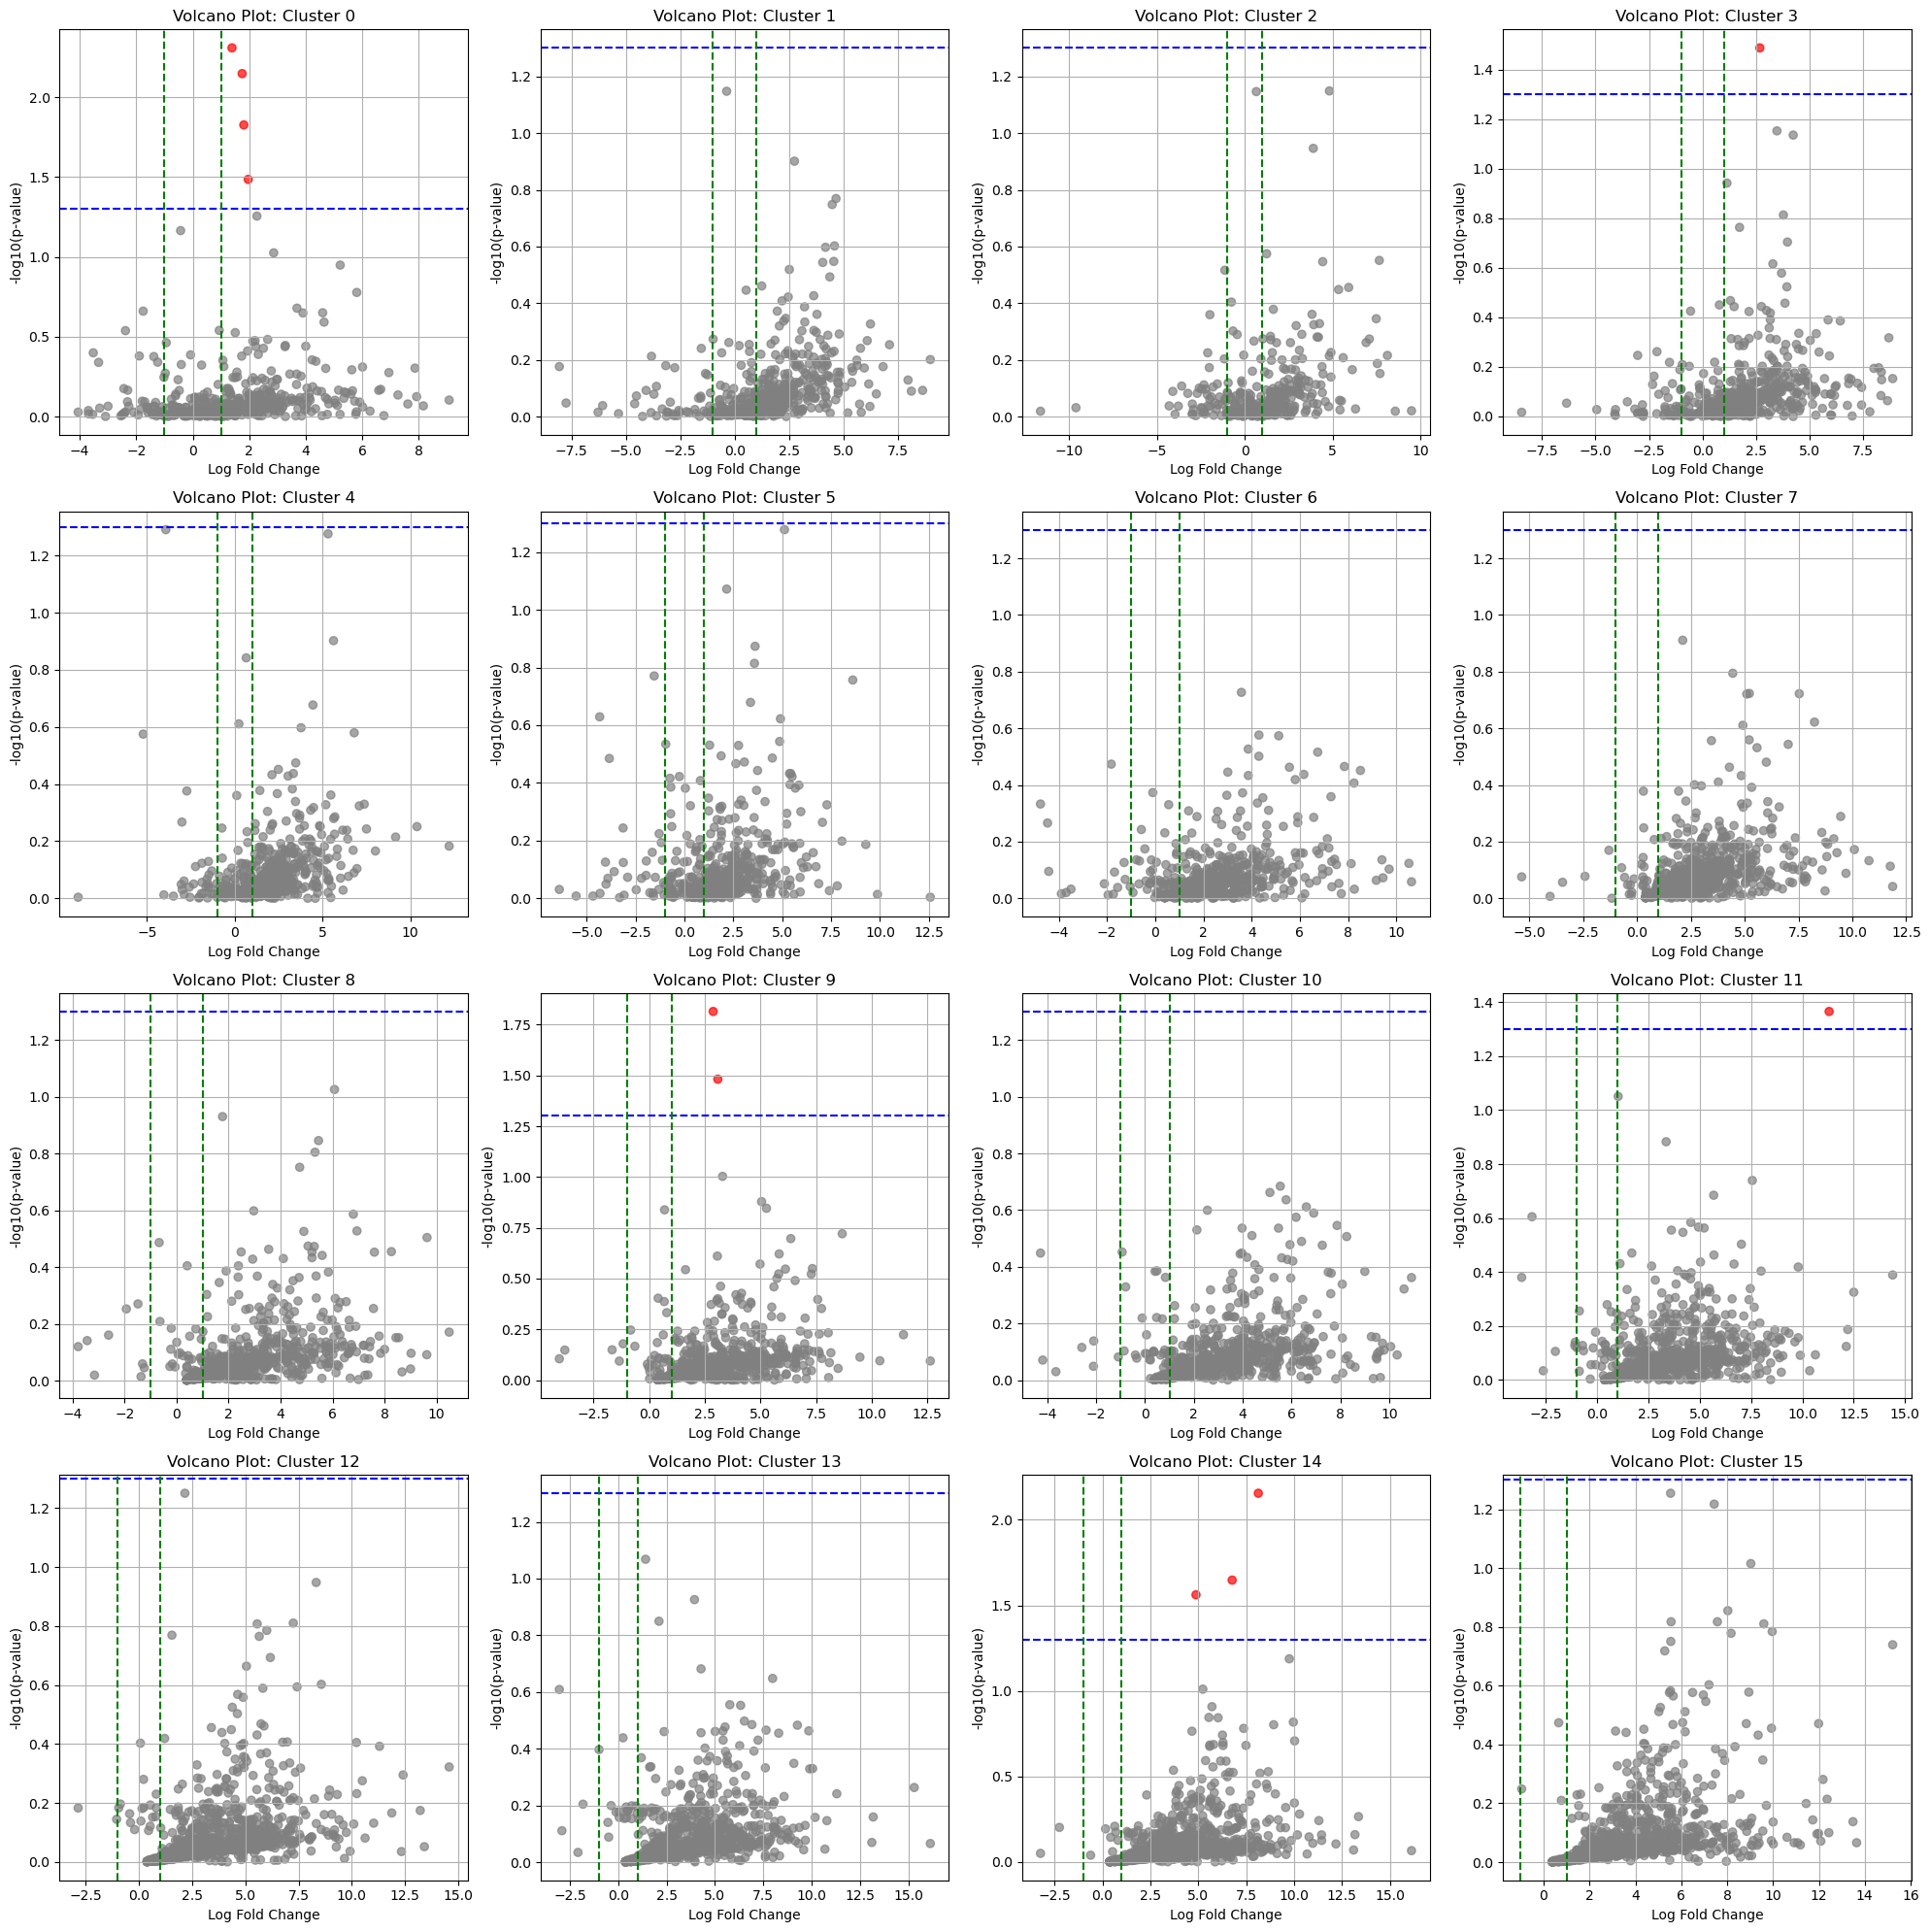

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()

groups = adata_filtered.obs['leiden_gat_0.6'].cat.categories

for i, group in enumerate(groups):
    if i >= len(axs):
        break

    names = adata_filtered.uns['rank_genes_gat']['names'][group]
    logfc = adata_filtered.uns['rank_genes_gat']['logfoldchanges'][group]
    pvals = adata_filtered.uns['rank_genes_gat']['pvals'][group]

    volcano_df = pd.DataFrame({
        'gene': names,
        'logFC': logfc,
        'pval': pvals
    })

    volcano_df['neg_log10_pval'] = -np.log10(volcano_df['pval'])

    volcano_df['significant'] = (volcano_df['pval'] < 0.05) & (abs(volcano_df['logFC']) > 1)

    ax = axs[i]
    ax.scatter(volcano_df['logFC'], volcano_df['neg_log10_pval'],
               c=volcano_df['significant'].map({True: 'red', False: 'gray'}),
               alpha=0.7)
    ax.set_title(f'Volcano Plot: Cluster {group}')
    ax.set_xlabel('Log Fold Change')
    ax.set_ylabel('-log10(p-value)')
    ax.axhline(-np.log10(0.05), color='blue', linestyle='--')
    ax.axvline(1, color='green', linestyle='--')
    ax.axvline(-1, color='green', linestyle='--')
    ax.grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
